# Empirische Analyse von Prior-Daten Konflikten in BNNs

## Tiefe BNNs

### Import der benötigten Pakete und definieren der Loss-Funktion

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
from scipy.stats import multivariate_normal, norm, uniform, norm, beta, bernoulli
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
import seaborn as sns

%matplotlib inline

2023-05-03 14:19:09.537355: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Applications/anaconda3/envs/abgabe/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
neg_log_like = lambda y, rv_y: -rv_y.log_prob(y)

In [3]:
import random
np.random.seed(123)
tf.random.set_seed(124)
random.seed(123)

In [4]:
plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
#Options
params = {'text.usetex' : True,
          'font.size' : "18",
          'font.family' : 'lmodern',
          'legend.fontsize': "18", 
          }
plt.rcParams.update(params) 

/var/folders/zp/1hx5lv0d4b95fw3_z7q4t74h0000gn/T/ipykernel_33285/514745690.py:1: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]


In [5]:
# Wird für Violinplots genutzt, um Labels hinzuzufügen
def add_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))

### Generierung des synthetischen Datensatzes

In [6]:
# Sample Data
n10 = 10
n100 = 100
n1000 = 1000
X = np.random.normal( size = (n1000, 1))
y = np.random.normal(np.cos(5 * X) / (np.abs(X) + 1) + 100, .5).ravel()
X = np.hstack((X, X**2, X**3))

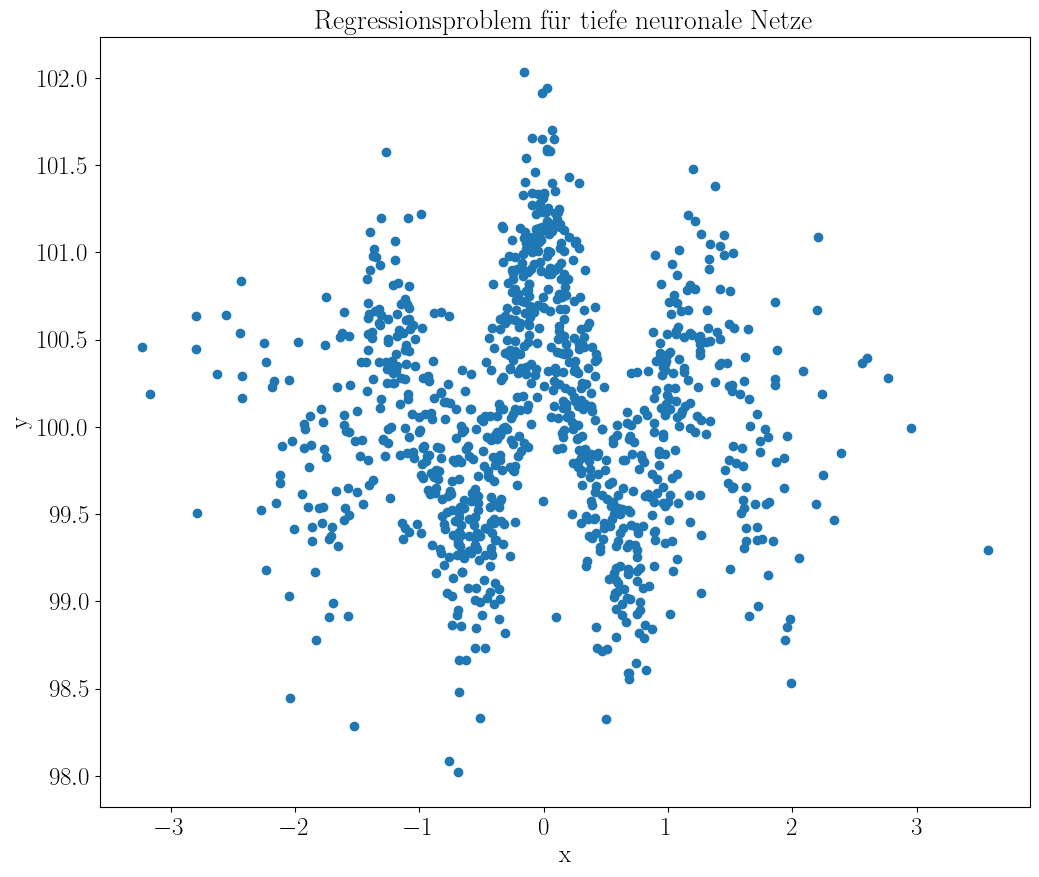

In [7]:
plt.figure(figsize=(12,10))
plt.scatter(X[:, 0], y)
plt.xlabel("x")
plt.ylabel("y")
plt.rc('font', size=10)        
plt.rc('axes', titlesize=20)  
plt.title("Regressionsproblem für tiefe neuronale Netze")
plt.show()

In [8]:
n_features = X.shape[1]
n_hidden = 100
n_out = 1

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(n_features,)),
    tf.keras.layers.Dense(n_hidden, activation = "relu", kernel_initializer=tf.keras.initializers.RandomNormal(10, 1), bias_initializer=tf.keras.initializers.RandomNormal(10, 1)),
    tf.keras.layers.Dense(n_hidden, activation = "relu", kernel_initializer=tf.keras.initializers.RandomNormal(10, 1), bias_initializer=tf.keras.initializers.RandomNormal(10, 1)),

    tf.keras.layers.Dense(n_out, kernel_initializer=tf.keras.initializers.RandomNormal(10, 1), bias_initializer=tf.keras.initializers.RandomNormal(10, 1))
])

model.compile(optimizer=tf.optimizers.Adam(learning_rate=.01), loss = tf.losses.mean_squared_error)
history = model.fit(X, y, epochs=5000, verbose = False, batch_size=32)

2023-05-03 14:19:19.270245: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
X_pred = np.atleast_2d(np.linspace(-3, 3, num = 100)).T
X_pred = np.hstack((X_pred, X_pred ** 2, X_pred ** 3))

In [10]:
y_hat = model(X_pred)

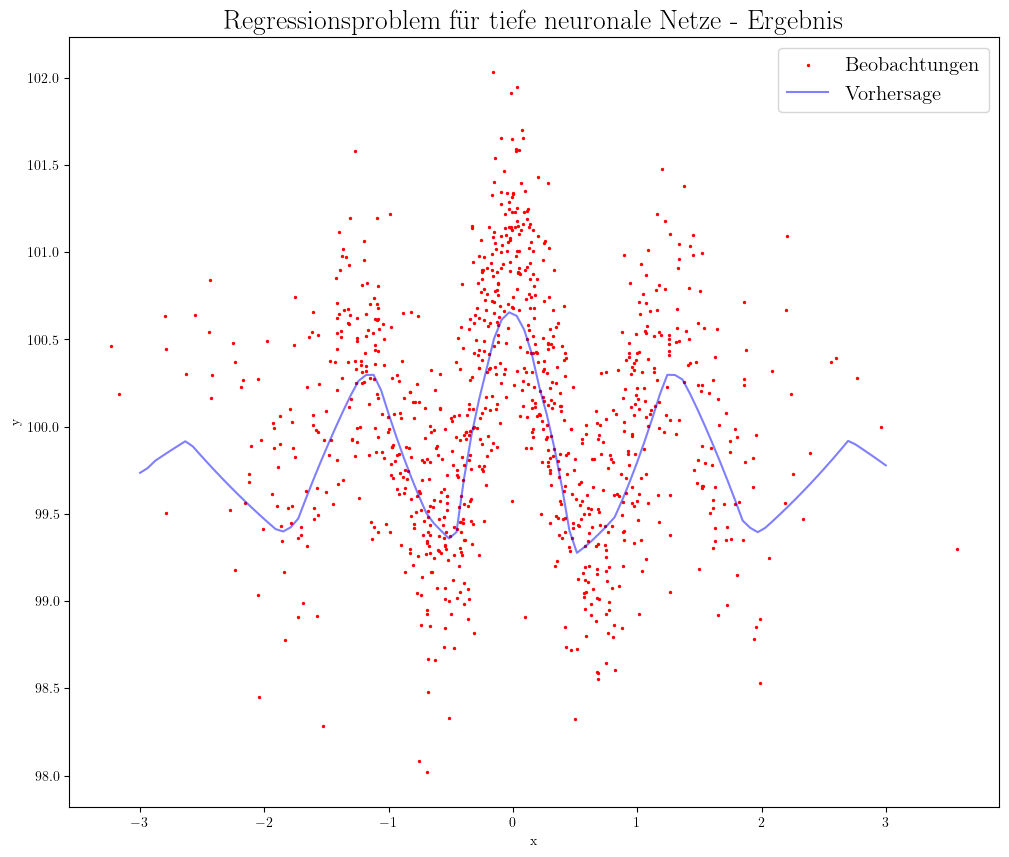

In [11]:
plt.figure(figsize=(12,10))
plt.scatter(X[:,0], y, color="red", s = 2, label="Beobachtungen")
plt.plot(X_pred[:,0], y_hat, alpha = 0.5, color = "blue", label="Vorhersage")
plt.xlabel("x")
plt.ylabel("y")
plt.rc('font', size=10)        
plt.rc('axes', titlesize=20)  
plt.rc('legend', fontsize=15)
plt.title("Regressionsproblem für tiefe neuronale Netze - Ergebnis")
plt.legend()
plt.show()

In [12]:
k1 = model.weights[0].numpy() # kernel of first layer
b1 = model.weights[1].numpy() # bias of first layer
k2 = model.weights[2].numpy() # kernel of second layer
b2 = model.weights[3].numpy() # bias of second layer
k3 = model.weights[4].numpy() # kernel of third layer
b3 = model.weights[5].numpy() # bias of third layer

In [13]:
# Use previous weights as ground truth
aleatoric_noise = .1
X_pred = np.atleast_2d(np.random.normal(0, .5, size = (30000,))).T
X_pred = np.hstack((X_pred, X_pred ** 2, X_pred ** 3))
y_true = np.random.normal(model(X_pred), aleatoric_noise)

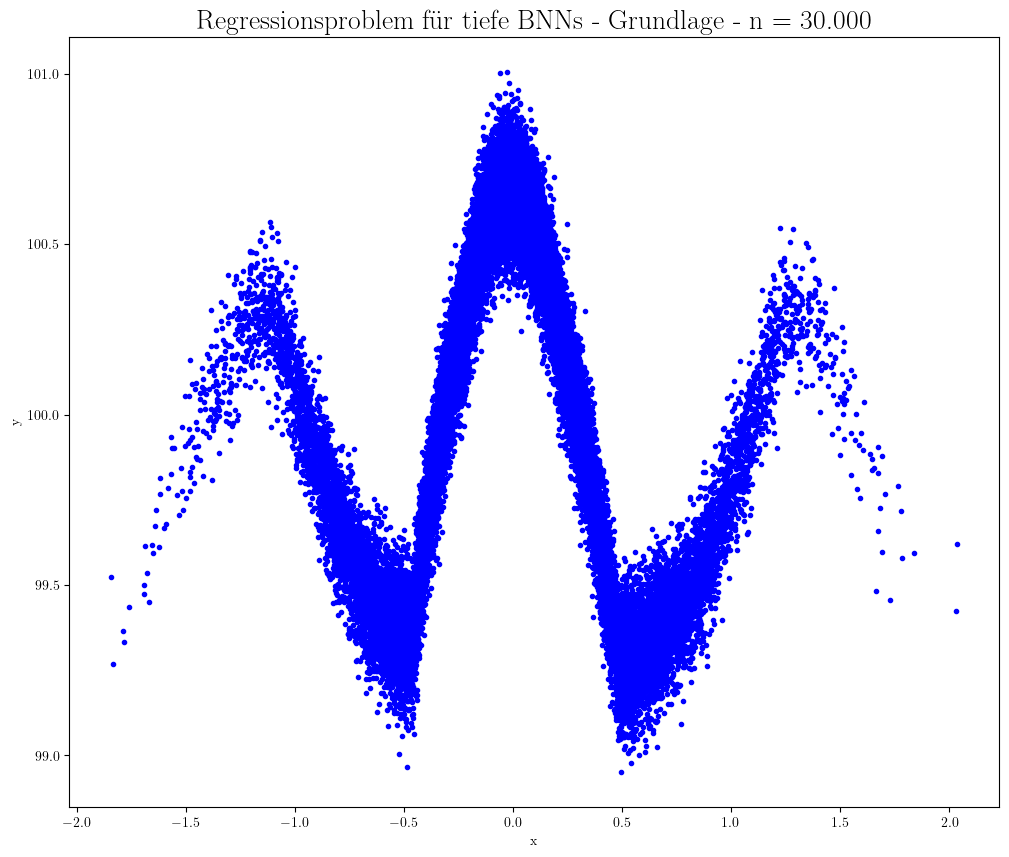

In [14]:
plt.figure(figsize=(12,10))
plt.plot(X_pred[:,0], y_true, "b.")
plt.xlabel("x")
plt.ylabel("y")
plt.rc('font', size=10)        
plt.rc('axes', titlesize=20)  
plt.title("Regressionsproblem für tiefe BNNs - Grundlage - n = 30.000")
plt.show()

## Definition der Prior- und Posterior-Verteilung

In [15]:
### Priors
## Prior Daten Konflikt
# N(0, I)
def prior_base(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size # num of params
    return tf.keras.Sequential([
       tfp.layers.DistributionLambda(
           #lambda t: tfp.distributions.Independent(tfp.distributions.Normal(loc = 0, scale=1))
           #lambda t: tfp.distributions.Normal(loc = tf.zeros(n), scale= tf.ones(n))
           lambda t: tfp.distributions.MultivariateNormalDiag(loc = tf.zeros(n), scale_diag=tf.ones(n))
       )                     
  ])

# N(0, 10I)
def prior_base_10(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size # num of params
    return tf.keras.Sequential([
       tfp.layers.DistributionLambda(
           #lambda t: tfp.distributions.Independent(tfp.distributions.Normal(loc = 0, scale=1))
           #lambda t: tfp.distributions.Normal(loc = tf.zeros(n), scale= tf.ones(n))
           lambda t: tfp.distributions.MultivariateNormalDiag(loc = tf.zeros(n), scale_diag=tf.ones(n) * np.sqrt(10))
       )                     
  ])

# N(0, 0.1I)
def prior_base_p1(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size # num of params
    return tf.keras.Sequential([
       tfp.layers.DistributionLambda(
           #lambda t: tfp.distributions.Independent(tfp.distributions.Normal(loc = 0, scale=1))
           #lambda t: tfp.distributions.Normal(loc = tf.zeros(n), scale= tf.ones(n))
           lambda t: tfp.distributions.MultivariateNormalDiag(loc = tf.zeros(n), scale_diag=tf.ones(n) * np.sqrt(.1))
       )                     
  ])


## Kein Prior-Daten Konflikt
# N(., I)
def prior_exact_I(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size # num of params
    return tf.keras.Sequential([
       tfp.layers.DistributionLambda(
           #lambda t: tfp.distributions.Independent(tfp.distributions.Normal(loc = 0, scale=1))
           #lambda t: tfp.distributions.Normal(loc = tf.ones(n) * np.hstack((k1.ravel(), b1.ravel())), scale= tf.ones(n) * .1)
           lambda t: tfp.distributions.MultivariateNormalDiag(loc = tf.ones(n) * np.hstack((k1.ravel(), b1.ravel())), scale_diag= tf.ones(n))
       )                     
  ])

def prior_exact_I1(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size # num of params
    return tf.keras.Sequential([
       tfp.layers.DistributionLambda(
           #lambda t: tfp.distributions.Independent(tfp.distributions.Normal(loc = 0, scale=1))
           #lambda t: tfp.distributions.Normal(loc = tf.ones(n) * np.hstack((k2.ravel(), b2.ravel())), scale= tf.ones(n) * .1)
           lambda t: tfp.distributions.MultivariateNormalDiag(loc = tf.ones(n) * np.hstack((k2.ravel(), b2.ravel())), scale_diag= tf.ones(n))
       )                     
  ])

def prior_exact_I2(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size # num of params
    return tf.keras.Sequential([
       tfp.layers.DistributionLambda(
           #lambda t: tfp.distributions.Independent(tfp.distributions.Normal(loc = 0, scale=1))
           #lambda t: tfp.distributions.Normal(loc = tf.ones(n) * np.hstack((k3.ravel(), b3.ravel())), scale= tf.ones(n) * .1)
           lambda t: tfp.distributions.MultivariateNormalDiag(loc = tf.ones(n) * np.hstack((k3.ravel(), b3.ravel())), scale_diag= tf.ones(n))
       )                     
  ])


# N(., 10I)
def prior_exact_10(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size # num of params
    return tf.keras.Sequential([
       tfp.layers.DistributionLambda(
           #lambda t: tfp.distributions.Independent(tfp.distributions.Normal(loc = 0, scale=1))
           #lambda t: tfp.distributions.Normal(loc = tf.ones(n) * np.hstack((k1.ravel(), b1.ravel())), scale= tf.ones(n) * .1)
           lambda t: tfp.distributions.MultivariateNormalDiag(loc = tf.ones(n) * np.hstack((k1.ravel(), b1.ravel())), scale_diag= tf.ones(n) * np.sqrt(10))
       )                     
  ])

def prior_exact_10_1(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size # num of params
    return tf.keras.Sequential([
       tfp.layers.DistributionLambda(
           #lambda t: tfp.distributions.Independent(tfp.distributions.Normal(loc = 0, scale=1))
           #lambda t: tfp.distributions.Normal(loc = tf.ones(n) * np.hstack((k2.ravel(), b2.ravel())), scale= tf.ones(n) * .1)
           lambda t: tfp.distributions.MultivariateNormalDiag(loc = tf.ones(n) * np.hstack((k2.ravel(), b2.ravel())), scale_diag= tf.ones(n) * np.sqrt(10))
       )                     
  ])

def prior_exact_10_2(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size # num of params
    return tf.keras.Sequential([
       tfp.layers.DistributionLambda(
           #lambda t: tfp.distributions.Independent(tfp.distributions.Normal(loc = 0, scale=1))
           #lambda t: tfp.distributions.Normal(loc = tf.ones(n) * np.hstack((k3.ravel(), b3.ravel())), scale= tf.ones(n) * .1)
           lambda t: tfp.distributions.MultivariateNormalDiag(loc = tf.ones(n) * np.hstack((k3.ravel(), b3.ravel())), scale_diag= tf.ones(n) * np.sqrt(10))
       )                     
  ])

def prior_exact_p1(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size # num of params
    return tf.keras.Sequential([
       tfp.layers.DistributionLambda(
           #lambda t: tfp.distributions.Independent(tfp.distributions.Normal(loc = 0, scale=1))
           #lambda t: tfp.distributions.Normal(loc = tf.ones(n) * np.hstack((k1.ravel(), b1.ravel())), scale= tf.ones(n) * .1)
           lambda t: tfp.distributions.MultivariateNormalDiag(loc = tf.ones(n) * np.hstack((k1.ravel(), b1.ravel())), scale_diag= tf.ones(n) * np.sqrt(.1))
       )                     
  ])

def prior_exact_p1_1(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size # num of params
    return tf.keras.Sequential([
       tfp.layers.DistributionLambda(
           #lambda t: tfp.distributions.Independent(tfp.distributions.Normal(loc = 0, scale=1))
           #lambda t: tfp.distributions.Normal(loc = tf.ones(n) * np.hstack((k2.ravel(), b2.ravel())), scale= tf.ones(n) * .1)
           lambda t: tfp.distributions.MultivariateNormalDiag(loc = tf.ones(n) * np.hstack((k2.ravel(), b2.ravel())), scale_diag= tf.ones(n) * np.sqrt(.1))
       )                     
  ])

def prior_exact_p1_2(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size # num of params
    return tf.keras.Sequential([
       tfp.layers.DistributionLambda(
           #lambda t: tfp.distributions.Independent(tfp.distributions.Normal(loc = 0, scale=1))
           #lambda t: tfp.distributions.Normal(loc = tf.ones(n) * np.hstack((k3.ravel(), b3.ravel())), scale= tf.ones(n) * .1)
           lambda t: tfp.distributions.MultivariateNormalDiag(loc = tf.ones(n) * np.hstack((k3.ravel(), b3.ravel())), scale_diag= tf.ones(n) * np.sqrt(.1))
       )                     
  ])


### Posterior
# mean-field posterior
def posterior(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size # num of params
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2*n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfp.distributions.Independent(
            tfp.distributions.Normal(loc = t[..., :n], scale = 1e-5 + tf.math.softplus(t[...,n:]) )
        ))
    ])





## Analyse des Effekts eines Prior-Daten Konfliktes

### Prior-Daten Konflikt

In [16]:
batch_size = 1000
kl_weight = 1/int(X_pred.shape[0]/batch_size)
cb = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=1e-4, patience = 500, mode = "min", verbose = 1)

base_model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(3,)), 
    tfp.layers.DenseVariational(units=100, make_posterior_fn=posterior, make_prior_fn=prior_base, kl_weight=kl_weight),
    tf.keras.layers.Activation("relu"),
    tfp.layers.DenseVariational(units=100, make_posterior_fn=posterior, make_prior_fn=prior_base, kl_weight=kl_weight),
    tf.keras.layers.Activation("relu"),
    tfp.layers.DenseVariational(units=1, make_posterior_fn=posterior, make_prior_fn=prior_base, kl_weight=kl_weight),
    tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc = t, scale=.1))
])
base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss = neg_log_like)
base_model.fit(X_pred, y_true, epochs = 10000, verbose = False, batch_size = batch_size, callbacks=cb, validation_split=.3)
#base_model.build()

Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
Epoch 1462: early stopping


In [17]:
X_pred_ = np.atleast_2d(np.linspace(-2,2, 100)).T
X_pred_ = np.hstack((X_pred_, X_pred_**2, X_pred_**3))


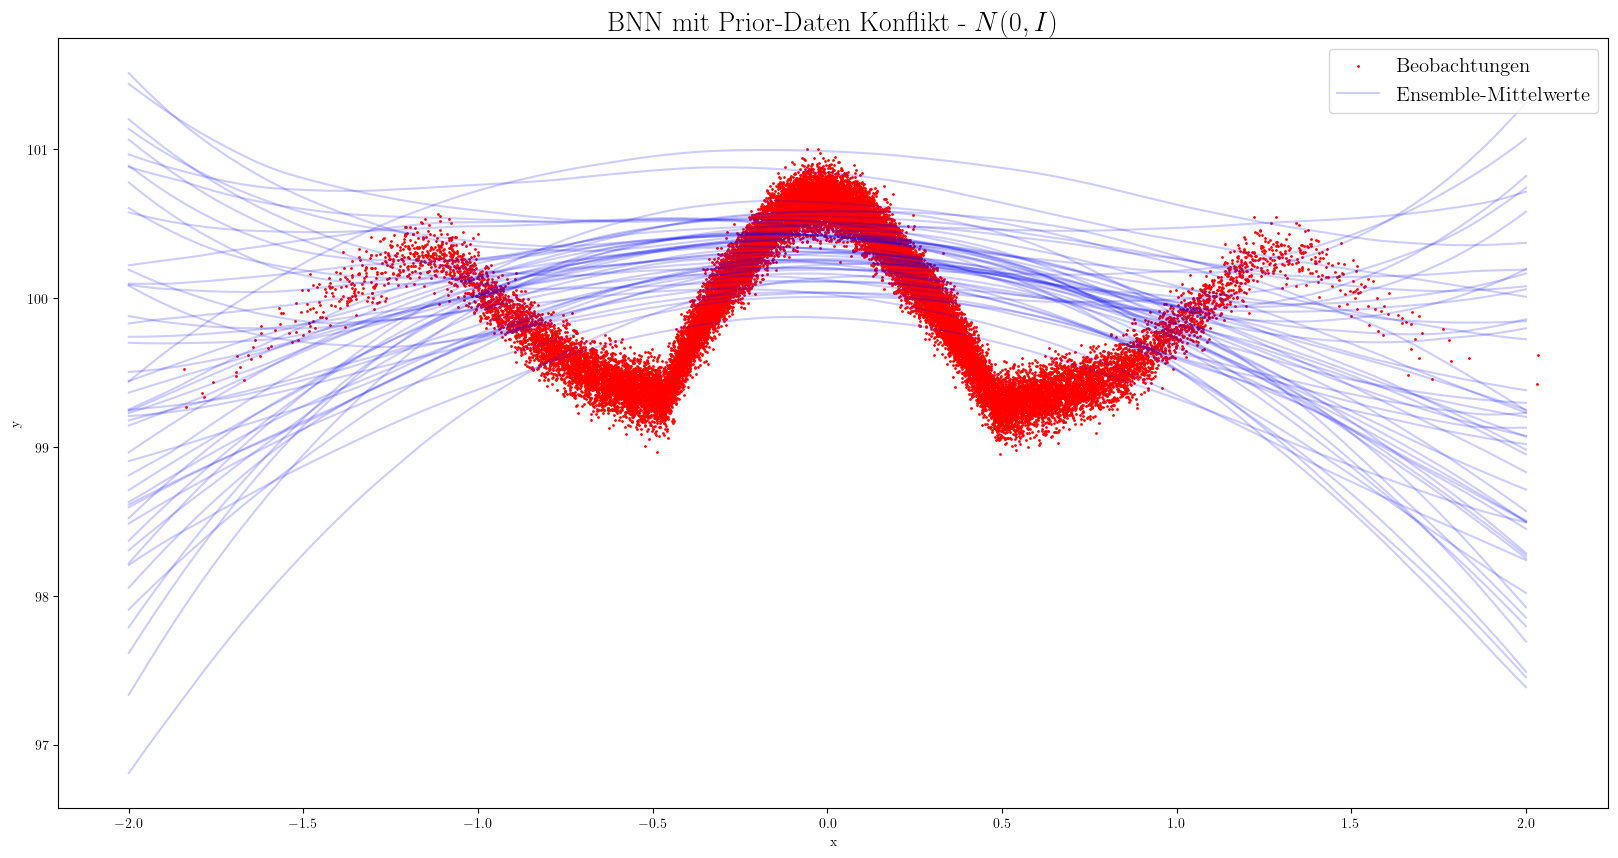

In [18]:
plt.figure(figsize=(20,10))
plt.scatter(X_pred[:,0], y_true, color="red", s=1, label="Beobachtungen")
plt.title(r"BNN mit Prior-Daten Konflikt - $N(0, I)$")
plt.xlabel("x")
plt.ylabel("y")
for i in range(50):
    plt.plot(X_pred_[:,0], base_model(X_pred_).mean(), color= "blue", alpha = .2, label="Ensemble-Mittelwerte" if i == 0 else None)
plt.legend(loc="upper right")
plt.savefig("bilder/deep_bnn/dbnn_prior_I.png", dpi=1000, bbox_inches='tight')
plt.show()

Abweichung der Erwartungswerte von den wahren Gewichten

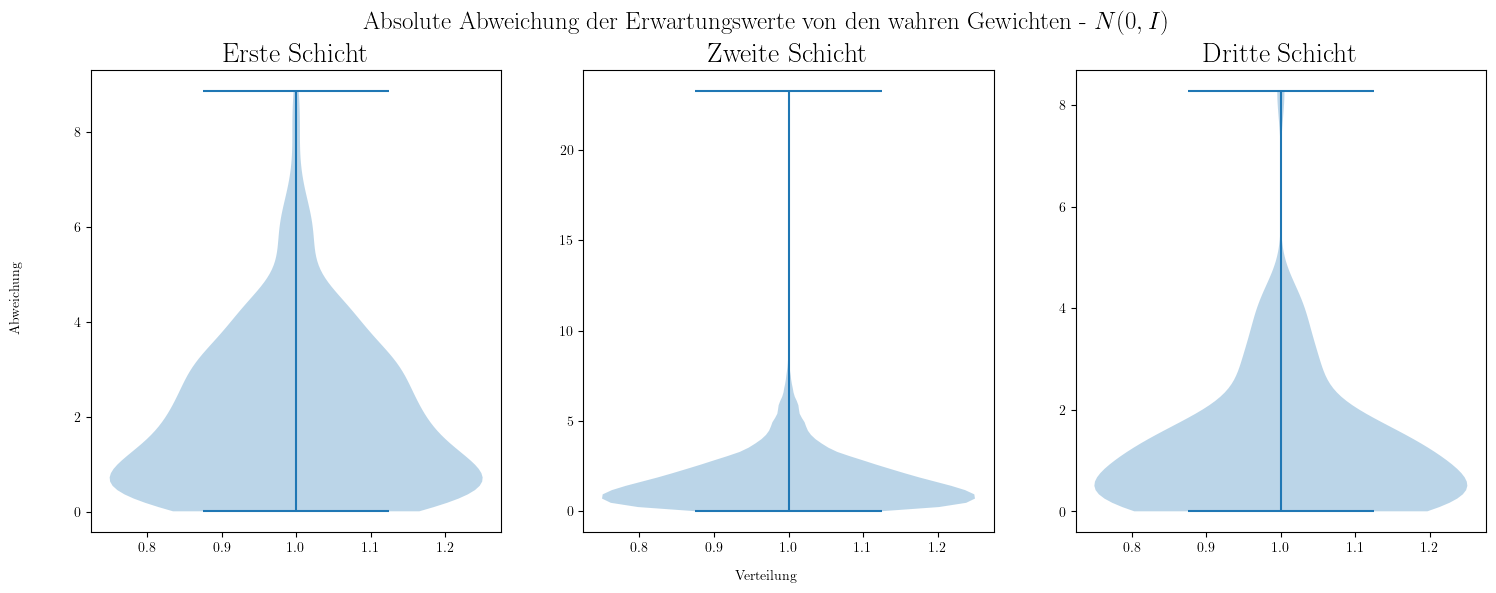

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18, 6))
ax1.violinplot(np.abs(np.hstack((k1.ravel(),b1.ravel())) - base_model.layers[0]._posterior(np.array([0])).mean().numpy()))
ax1.set_title("Erste Schicht")
ax2.violinplot(np.abs(np.hstack((k2.ravel(),b2.ravel())) - base_model.layers[2]._posterior(np.array([0])).mean().numpy()))
ax2.set_title("Zweite Schicht")
ax3.violinplot(np.abs(np.hstack((k3.ravel(),b3.ravel())) - base_model.layers[4]._posterior(np.array([0])).mean().numpy()))
ax3.set_title("Dritte Schicht")
fig.text(0.5, .95, r"Absolute Abweichung der Erwartungswerte von den wahren Gewichten - $N(0, I)$", ha="center", fontsize=18)
fig.text(0.5, 0.03, 'Verteilung', ha='center')
fig.text(0.08, 0.5, 'Abweichung', va='center', rotation='vertical')
plt.savefig("bilder/deep_bnn/dbnn_prior_I_evals.png", dpi=1000, bbox_inches='tight')
plt.show()

Durchschnittliche Varianz

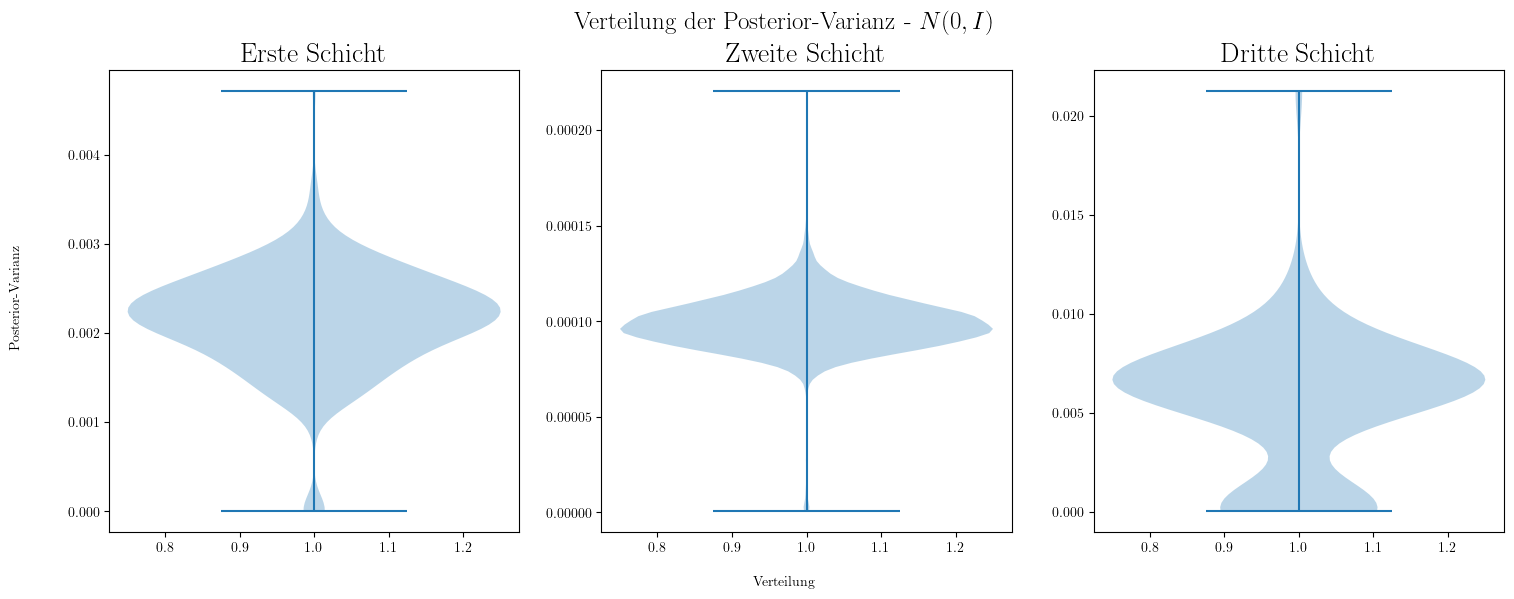

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18, 6))
ax1.violinplot(np.power(base_model.layers[0]._posterior(np.array([0])).stddev().numpy(), 2))
ax1.set_title("Erste Schicht")
ax2.violinplot(np.power(base_model.layers[2]._posterior(np.array([0])).stddev().numpy(), 2))
ax2.set_title("Zweite Schicht")
ax3.violinplot(np.power(base_model.layers[4]._posterior(np.array([0])).stddev().numpy(), 2))
ax3.set_title("Dritte Schicht")
fig.text(0.5, .95, r"Verteilung der Posterior-Varianz - $N(0, I)$", ha="center", fontsize=18)
fig.text(0.5, 0.02, 'Verteilung', ha='center')
fig.text(0.07, 0.5, 'Posterior-Varianz', va='center', rotation='vertical')
plt.savefig("bilder/deep_bnn/dbnn_prior_I_stddev.png", dpi=1000, bbox_inches='tight')
plt.show()

### Exakte Priors

In [21]:
batch_size = 1000
kl_weight = 1/int(X_pred.shape[0]/batch_size)
cb = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=1e-4, patience = 500, mode = "min", verbose = 1)

ideal_model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(3,)), 
    tfp.layers.DenseVariational(units=100, make_posterior_fn=posterior, make_prior_fn=prior_exact_I, kl_weight=kl_weight),
    tf.keras.layers.Activation("relu"),
    tfp.layers.DenseVariational(units=100, make_posterior_fn=posterior, make_prior_fn=prior_exact_I1, kl_weight=kl_weight),
    tf.keras.layers.Activation("relu"),
    tfp.layers.DenseVariational(units=1, make_posterior_fn=posterior, make_prior_fn=prior_exact_I2, kl_weight=kl_weight),
    tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc = t, scale=.1))
])
ideal_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss = neg_log_like)
ideal_model.fit(X_pred, y_true, epochs = 10000, verbose = False, batch_size = batch_size, callbacks=cb, validation_split=.3)
#base_model.build()

Epoch 2112: early stopping


In [22]:
X_pred_ = np.atleast_2d(np.linspace(-2,2, 100)).T
X_pred_ = np.hstack((X_pred_, X_pred_**2, X_pred_**3))


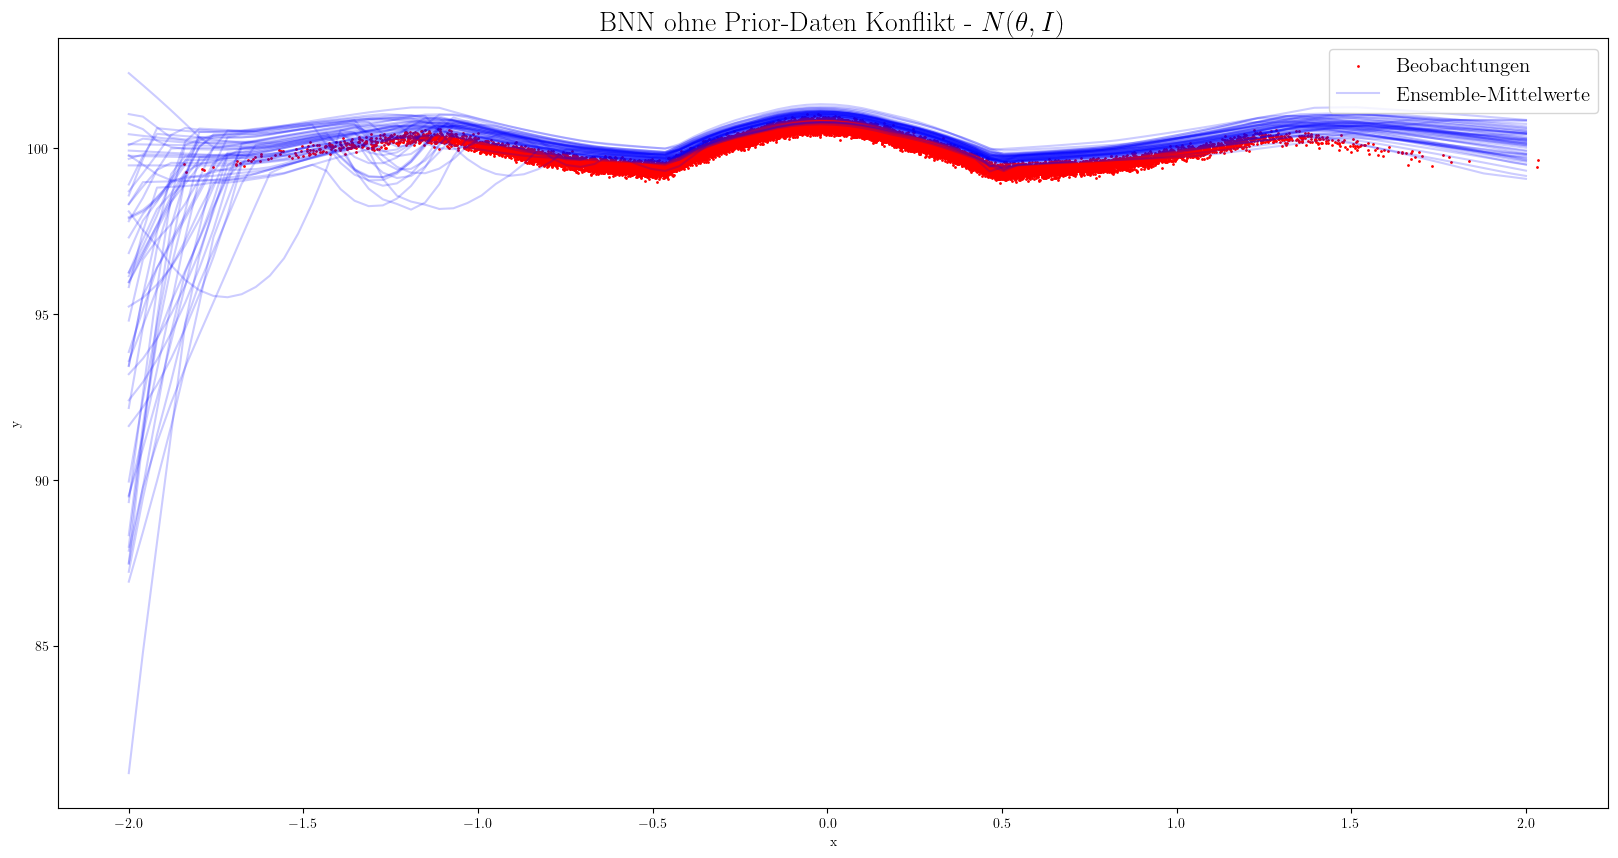

In [23]:
plt.figure(figsize=(20,10))
plt.scatter(X_pred[:,0], y_true, color="red", s=1, label="Beobachtungen")
plt.title(r"BNN ohne Prior-Daten Konflikt - $N(\theta,I)$")
plt.xlabel("x")
plt.ylabel("y")
for i in range(50):
    plt.plot(X_pred_[:,0], ideal_model(X_pred_).mean(), color= "blue", alpha = .2, label="Ensemble-Mittelwerte" if i == 0 else None)
plt.legend(loc="upper right")
plt.savefig("bilder/deep_bnn/dbnn_prior_exact_I.png", dpi=1000, bbox_inches='tight')
plt.show()

Erwartungswerte

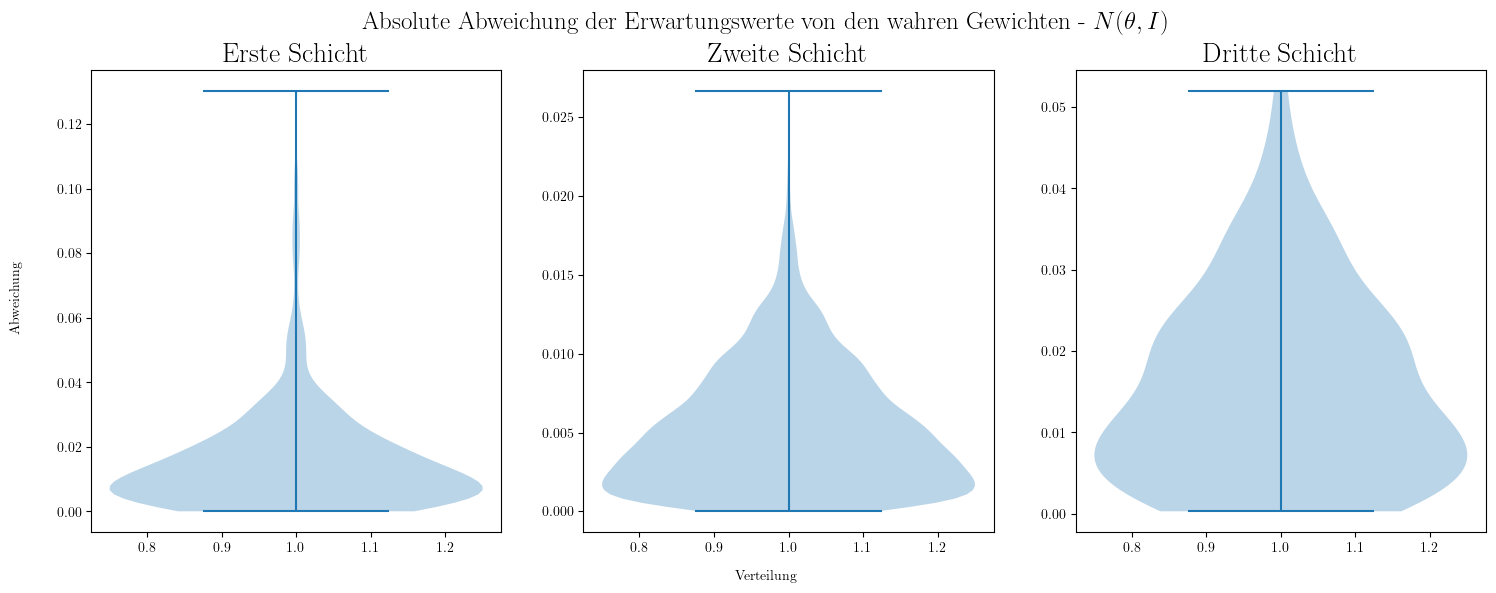

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18, 6))
ax1.violinplot(np.abs(np.hstack((k1.ravel(),b1.ravel())) - ideal_model.layers[0]._posterior(np.array([0])).mean().numpy()))
ax1.set_title("Erste Schicht")
ax2.violinplot(np.abs(np.hstack((k2.ravel(),b2.ravel())) - ideal_model.layers[2]._posterior(np.array([0])).mean().numpy()))
ax2.set_title("Zweite Schicht")
ax3.violinplot(np.abs(np.hstack((k3.ravel(),b3.ravel())) - ideal_model.layers[4]._posterior(np.array([0])).mean().numpy()))
ax3.set_title("Dritte Schicht")
fig.text(0.5, .95, r"Absolute Abweichung der Erwartungswerte von den wahren Gewichten - $N(\theta, I)$", ha="center", fontsize=18)
fig.text(0.5, 0.03, 'Verteilung', ha='center')
fig.text(0.08, 0.5, 'Abweichung', va='center', rotation='vertical')
plt.savefig("bilder/deep_bnn/dbnn_prior_exact_I_evals.png", dpi=1000, bbox_inches='tight')
plt.show()

Durchschnittliche Varianz

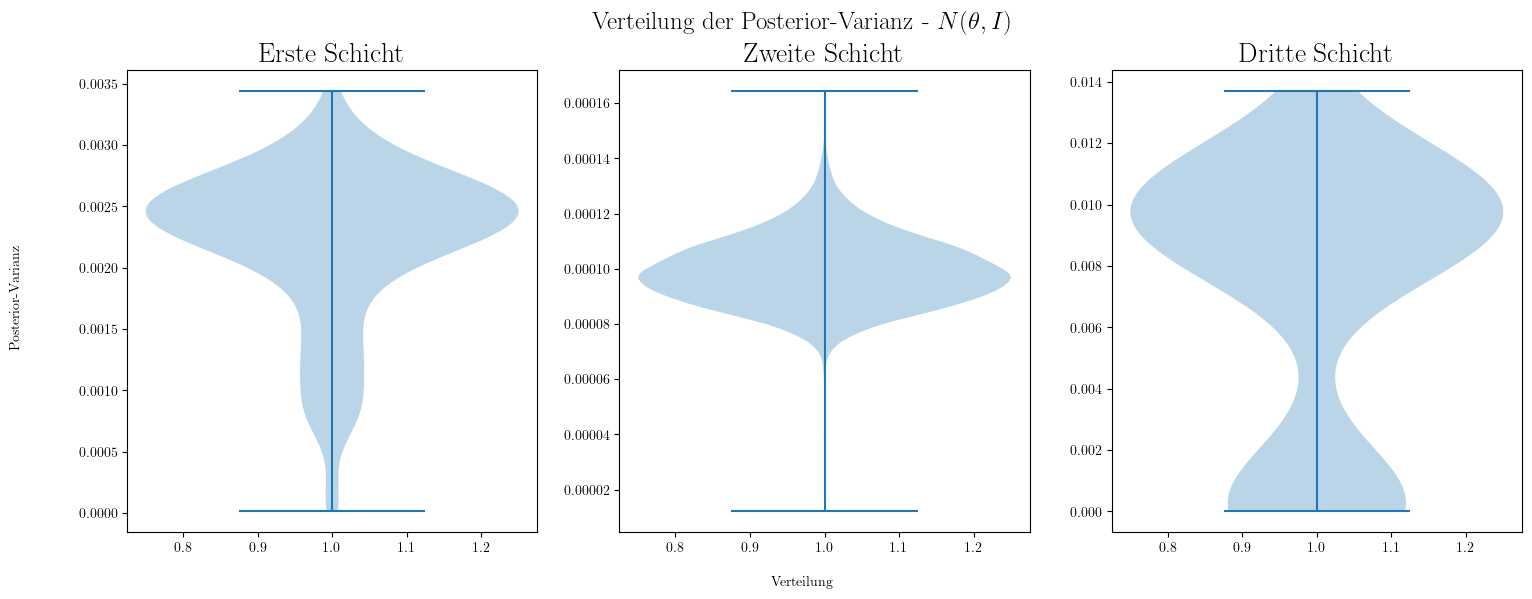

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18, 6))
ax1.violinplot(np.power(ideal_model.layers[0]._posterior(np.array([0])).stddev().numpy(), 2))
ax1.set_title("Erste Schicht")
ax2.violinplot(np.power(ideal_model.layers[2]._posterior(np.array([0])).stddev().numpy(), 2))
ax2.set_title("Zweite Schicht")
ax3.violinplot(np.power(ideal_model.layers[4]._posterior(np.array([0])).stddev().numpy(), 2))
ax3.set_title("Dritte Schicht")
fig.text(0.5, .95, r"Verteilung der Posterior-Varianz - $N(\theta, I)$", ha="center", fontsize=18)
fig.text(0.5, 0.02, 'Verteilung', ha='center')
fig.text(0.06, 0.5, 'Posterior-Varianz', va='center', rotation='vertical')
plt.savefig("bilder/deep_bnn/dbnn_prior_exact_I_stddev.png", dpi=1000, bbox_inches='tight')
plt.show()

Gegenüberstellung der Posterior Varianzen

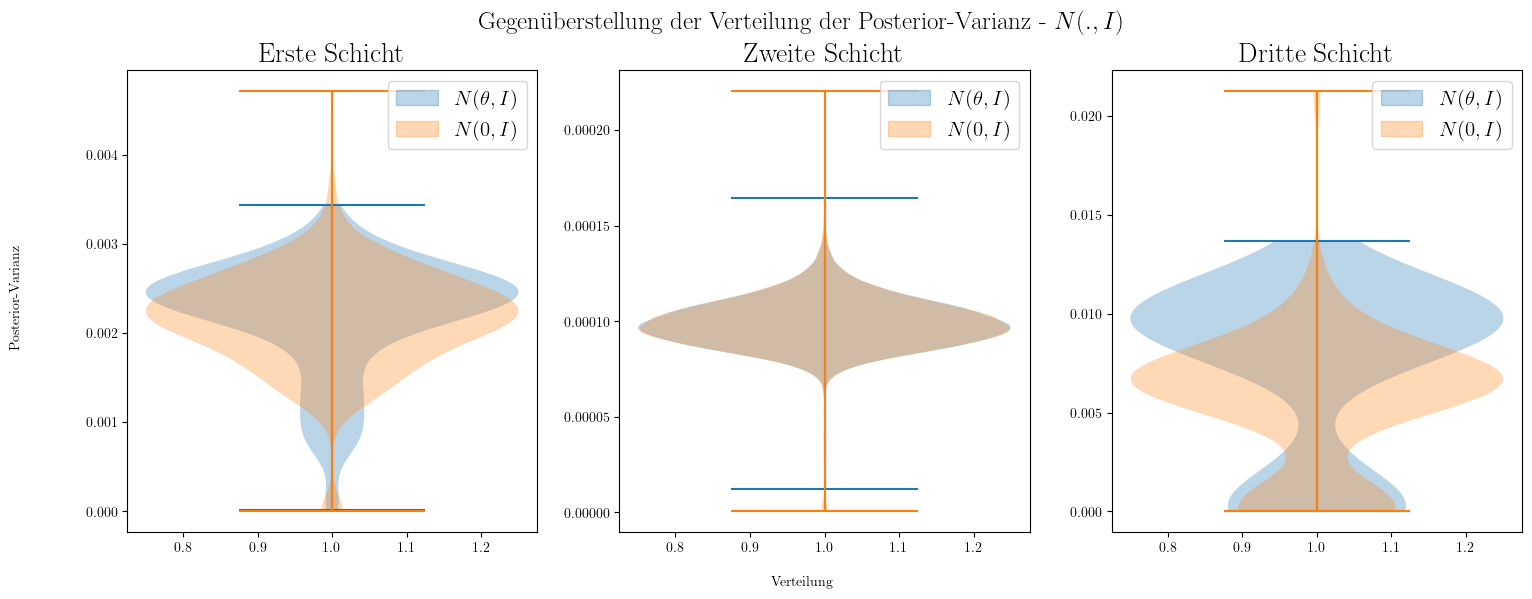

In [26]:
labels = []
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18, 6))
add_label(ax1.violinplot(np.power(ideal_model.layers[0]._posterior(np.array([0])).stddev().numpy(), 2)), r"$N(\theta, I)$")
add_label(ax1.violinplot(np.power(base_model.layers[0]._posterior(np.array([0])).stddev().numpy(), 2)), r"$N(0, I)$")
ax1.set_title("Erste Schicht")
ax1.legend(*zip(*labels), loc="upper right")
add_label(ax2.violinplot(np.power(ideal_model.layers[2]._posterior(np.array([0])).stddev().numpy(), 2)), r"$N(\theta, I)$")
add_label(ax2.violinplot(np.power(base_model.layers[2]._posterior(np.array([0])).stddev().numpy(), 2)), r"$N(0, I)$")
ax2.set_title("Zweite Schicht")
ax2.legend(*zip(*labels[2:]), loc="upper right")
add_label(ax3.violinplot(np.power(ideal_model.layers[4]._posterior(np.array([0])).stddev().numpy(), 2)), r"$N(\theta, I)$")
add_label(ax3.violinplot(np.power(base_model.layers[4]._posterior(np.array([0])).stddev().numpy(), 2)), r"$N(0, I)$")
ax3.set_title("Dritte Schicht")
ax3.legend(*zip(*labels[4:]), loc="upper right")
fig.text(0.5, .95, r"Gegenüberstellung der Verteilung der Posterior-Varianz - $N(., I)$", ha="center", fontsize=18)
fig.text(0.5, 0.02, 'Verteilung', ha='center')
fig.text(0.06, 0.5, 'Posterior-Varianz', va='center', rotation='vertical')
plt.savefig("bilder/deep_bnn/dbnn_prior_I_gegenueb", dpi=1000, bbox_inches='tight')
plt.show()

## Variation der Varianz

### N(., 10)

In [27]:
batch_size = 1000
kl_weight = 1/int(X_pred.shape[0]/batch_size)
cb = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=1e-4, patience = 500, mode = "min", verbose = 1)

base_model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(3,)), 
    tfp.layers.DenseVariational(units=100, make_posterior_fn=posterior, make_prior_fn=prior_base_10, kl_weight=kl_weight),
    tf.keras.layers.Activation("relu"),
    tfp.layers.DenseVariational(units=100, make_posterior_fn=posterior, make_prior_fn=prior_base_10, kl_weight=kl_weight),
    tf.keras.layers.Activation("relu"),
    tfp.layers.DenseVariational(units=1, make_posterior_fn=posterior, make_prior_fn=prior_base_10, kl_weight=kl_weight),
    tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc = t, scale=.1))
])
base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss = neg_log_like)
base_model.fit(X_pred, y_true, epochs = 10000, verbose = False, batch_size = batch_size, callbacks=cb, validation_split=.3)

Epoch 1930: early stopping


In [28]:
X_pred_ = np.atleast_2d(np.linspace(-2,2, 100)).T
X_pred_ = np.hstack((X_pred_, X_pred_**2, X_pred_**3))


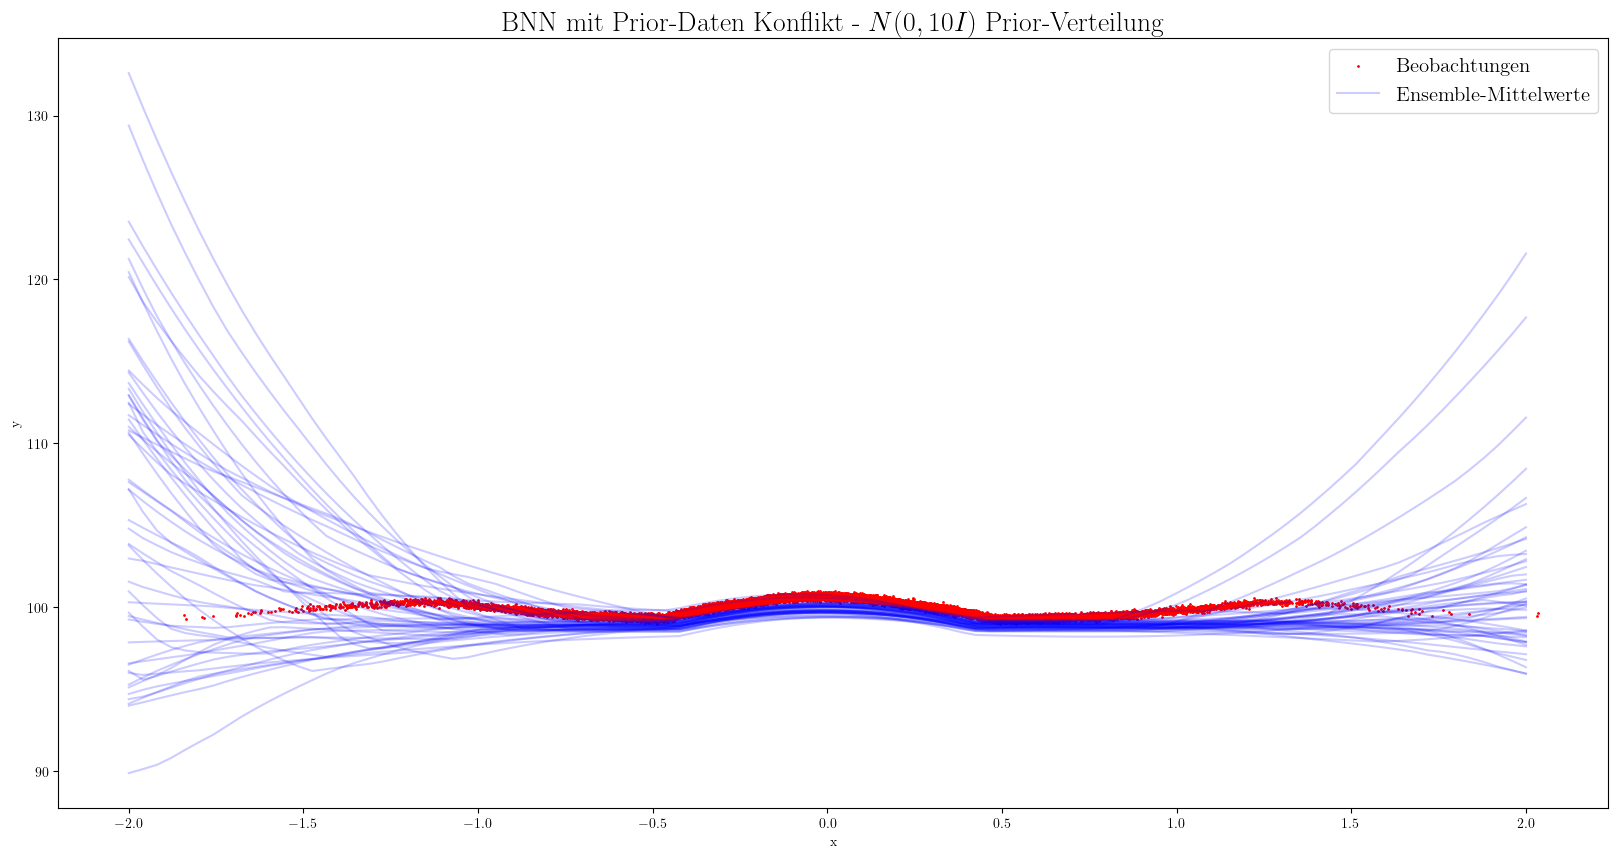

In [29]:
plt.figure(figsize=(20,10))
plt.scatter(X_pred[:,0], y_true, color="red", s=1, label="Beobachtungen")
plt.title(r"BNN mit Prior-Daten Konflikt - $N(0, 10I)$ Prior-Verteilung")
plt.xlabel("x")
plt.ylabel("y")
for i in range(50):
    plt.plot(X_pred_[:,0], base_model(X_pred_).mean(), color= "blue", alpha = .2, label="Ensemble-Mittelwerte" if i == 0 else None)
plt.legend(loc="upper right")
plt.savefig("bilder/deep_bnn/dbnn_prior_10.png", dpi=1000, bbox_inches='tight')
plt.show()

Erwartungswerte

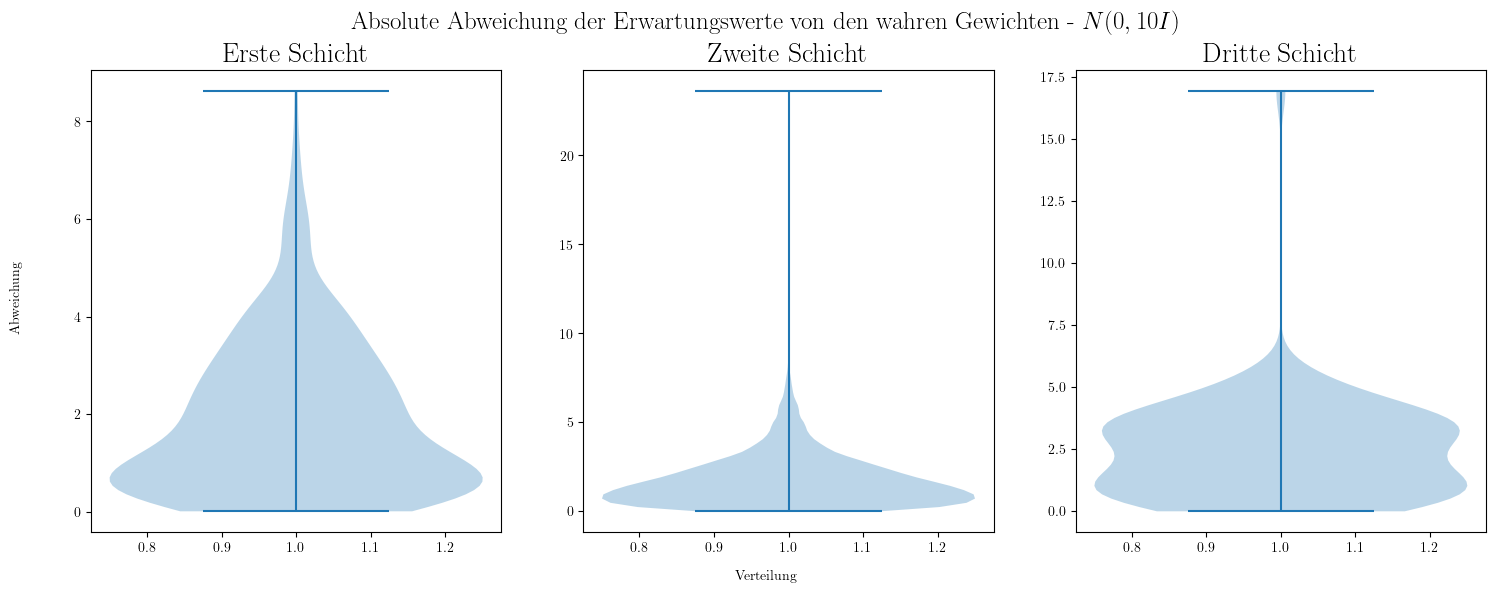

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18, 6))
ax1.violinplot(np.abs(np.hstack((k1.ravel(),b1.ravel())) - base_model.layers[0]._posterior(np.array([0])).mean().numpy()))
ax1.set_title("Erste Schicht")
ax2.violinplot(np.abs(np.hstack((k2.ravel(),b2.ravel())) - base_model.layers[2]._posterior(np.array([0])).mean().numpy()))
ax2.set_title("Zweite Schicht")
ax3.violinplot(np.abs(np.hstack((k3.ravel(),b3.ravel())) - base_model.layers[4]._posterior(np.array([0])).mean().numpy()))
ax3.set_title("Dritte Schicht")
fig.text(0.5, .95, r"Absolute Abweichung der Erwartungswerte von den wahren Gewichten - $N(0, 10I)$", ha="center", fontsize=18)
fig.text(0.5, 0.03, 'Verteilung', ha='center')
fig.text(0.08, 0.5, 'Abweichung', va='center', rotation='vertical')
plt.savefig("bilder/deep_bnn/dbnn_prior_10_evals.png", dpi=1000, bbox_inches='tight')
plt.show()

Durchschnittliche Varianz

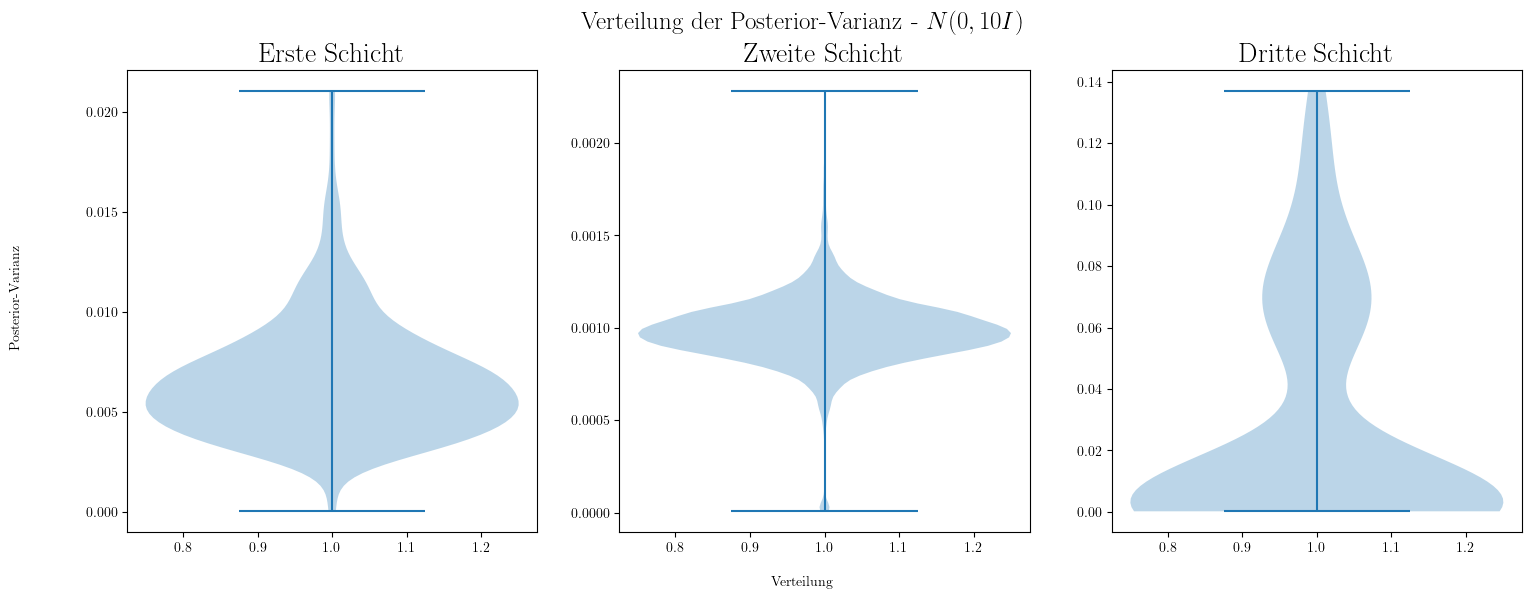

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18, 6))
ax1.violinplot(np.power(base_model.layers[0]._posterior(np.array([0])).stddev().numpy(), 2))
ax1.set_title("Erste Schicht")
ax2.violinplot(np.power(base_model.layers[2]._posterior(np.array([0])).stddev().numpy(), 2))
ax2.set_title("Zweite Schicht")
ax3.violinplot(np.power(base_model.layers[4]._posterior(np.array([0])).stddev().numpy(), 2))
ax3.set_title("Dritte Schicht")
fig.text(0.5, .95, r"Verteilung der Posterior-Varianz - $N(0, 10I)$", ha="center", fontsize=18)
fig.text(0.5, 0.02, 'Verteilung', ha='center')
fig.text(0.06, 0.5, 'Posterior-Varianz', va='center', rotation='vertical')
plt.savefig("bilder/deep_bnn/dbnn_prior_10_stddev.png", dpi=1000, bbox_inches='tight')
plt.show()

#### Kein Prior Daten Konflikt

In [32]:
batch_size = 1000
kl_weight = 1/int(X_pred.shape[0]/batch_size)
cb = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=1e-4, patience = 500, mode = "min", verbose = 1)

ideal_model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(3,)), 
    tfp.layers.DenseVariational(units=100, make_posterior_fn=posterior, make_prior_fn=prior_exact_10, kl_weight=kl_weight),
    tf.keras.layers.Activation("relu"),
    tfp.layers.DenseVariational(units=100, make_posterior_fn=posterior, make_prior_fn=prior_exact_10_1, kl_weight=kl_weight),
    tf.keras.layers.Activation("relu"),
    tfp.layers.DenseVariational(units=1, make_posterior_fn=posterior, make_prior_fn=prior_exact_10_2, kl_weight=kl_weight),
    tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc = t, scale=.1))
])
ideal_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss = neg_log_like)
ideal_model.fit(X_pred, y_true, epochs = 10000, verbose = False, batch_size = batch_size, callbacks=cb, validation_split=.3)
#base_model.build()

Epoch 2536: early stopping


In [33]:
X_pred_ = np.atleast_2d(np.linspace(-2,2, 100)).T
X_pred_ = np.hstack((X_pred_, X_pred_**2, X_pred_**3))


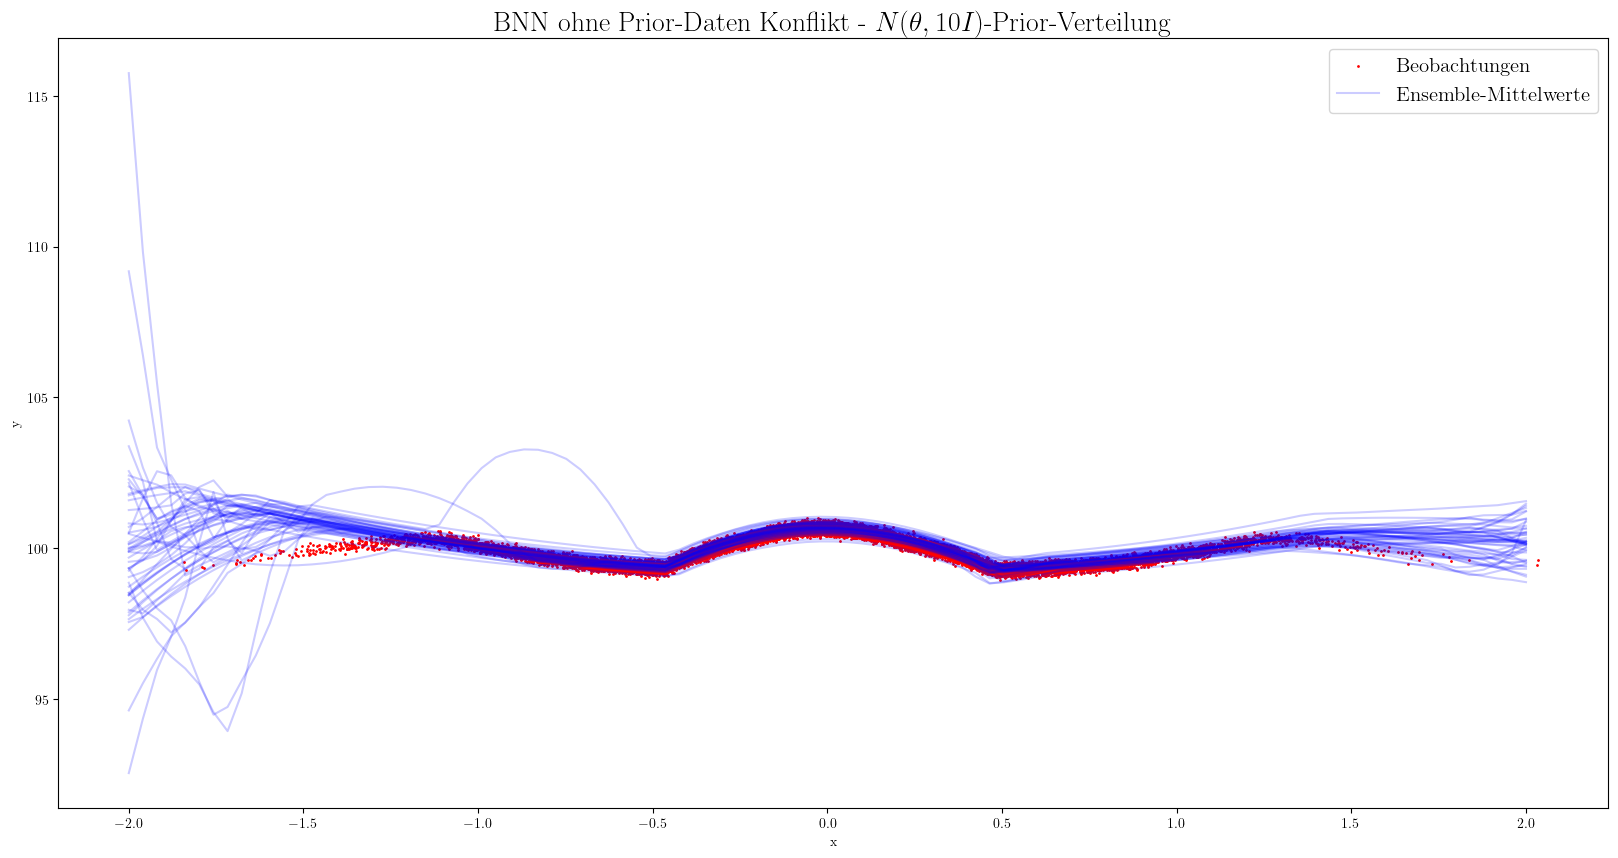

In [34]:
plt.figure(figsize=(20,10))
plt.scatter(X_pred[:,0], y_true, color="red", s=1, label="Beobachtungen")
plt.title(r"BNN ohne Prior-Daten Konflikt - $N(\theta, 10I)$-Prior-Verteilung")
plt.xlabel("x")
plt.ylabel("y")
for i in range(50):
    plt.plot(X_pred_[:,0], ideal_model(X_pred_).mean(), color= "blue", alpha = .2, label="Ensemble-Mittelwerte" if i == 0 else None)
plt.legend(loc="upper right")
plt.savefig("bilder/deep_bnn/dbnn_prior_exact_10.png", dpi=1000, bbox_inches='tight')
plt.show()

Erwartungswerte

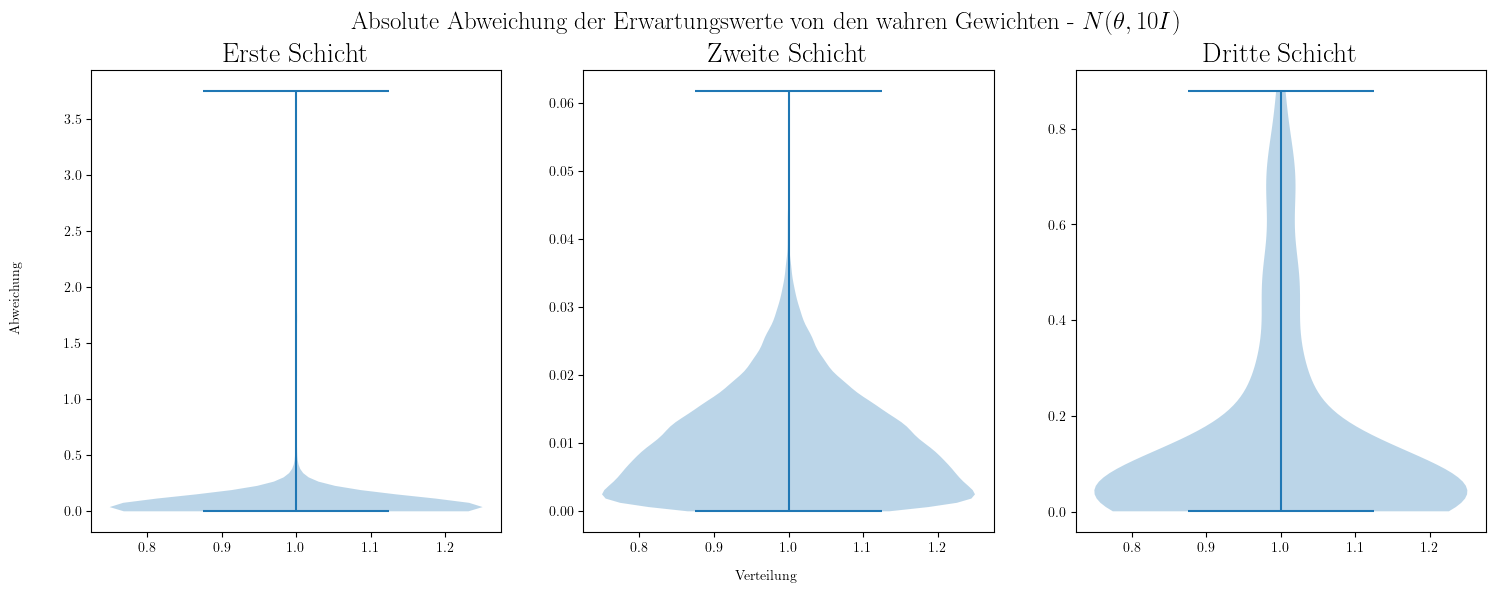

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18, 6))
ax1.violinplot(np.abs(np.hstack((k1.ravel(),b1.ravel())) - ideal_model.layers[0]._posterior(np.array([0])).mean().numpy()))
ax1.set_title("Erste Schicht")
ax2.violinplot(np.abs(np.hstack((k2.ravel(),b2.ravel())) - ideal_model.layers[2]._posterior(np.array([0])).mean().numpy()))
ax2.set_title("Zweite Schicht")
ax3.violinplot(np.abs(np.hstack((k3.ravel(),b3.ravel())) - ideal_model.layers[4]._posterior(np.array([0])).mean().numpy()))
ax3.set_title("Dritte Schicht")
fig.text(0.5, .95, r"Absolute Abweichung der Erwartungswerte von den wahren Gewichten - $N(\theta, 10I)$", ha="center", fontsize=18)
fig.text(0.5, 0.03, 'Verteilung', ha='center')
fig.text(0.08, 0.5, 'Abweichung', va='center', rotation='vertical')
plt.savefig("bilder/deep_bnn/dbnn_prior_exact_10_evals.png", dpi=1000, bbox_inches='tight')
plt.show()

Durchschnittliche Varianz

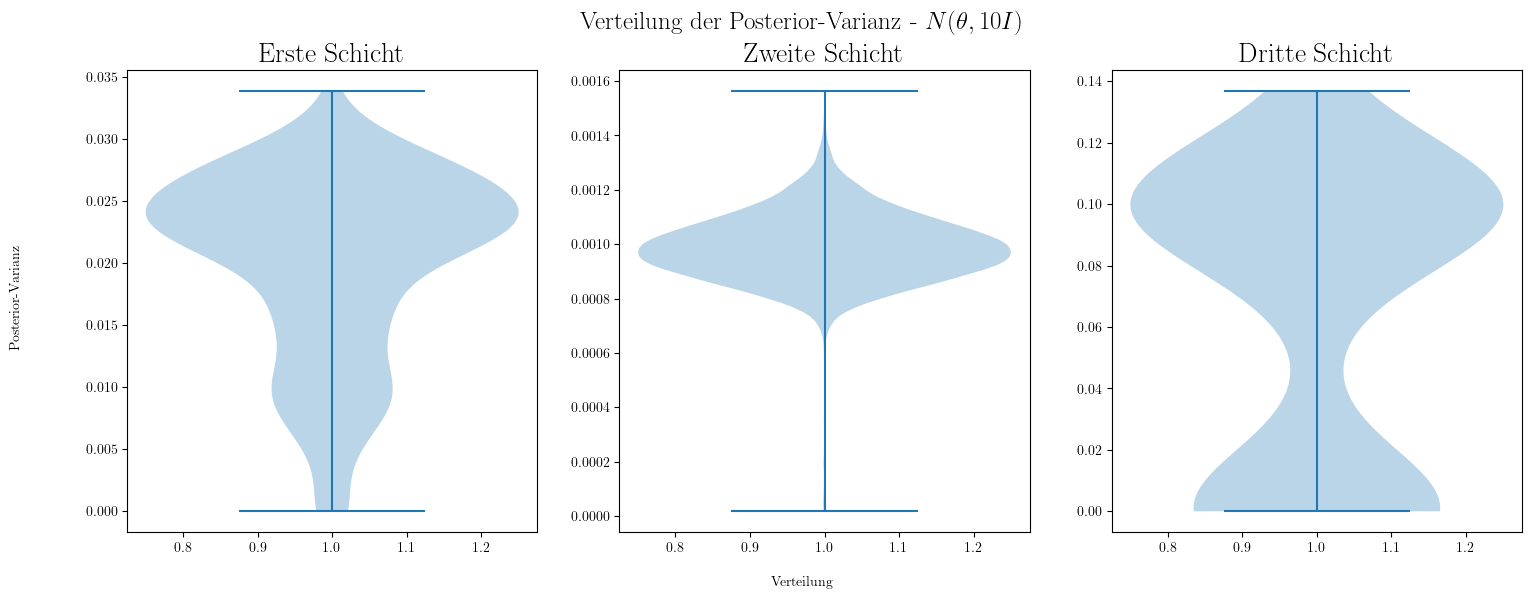

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18, 6))
ax1.violinplot(np.power(ideal_model.layers[0]._posterior(np.array([0])).stddev().numpy(), 2))
ax1.set_title("Erste Schicht")
ax2.violinplot(np.power(ideal_model.layers[2]._posterior(np.array([0])).stddev().numpy(), 2))
ax2.set_title("Zweite Schicht")
ax3.violinplot(np.power(ideal_model.layers[4]._posterior(np.array([0])).stddev().numpy(), 2))
ax3.set_title("Dritte Schicht")
fig.text(0.5, .95, r"Verteilung der Posterior-Varianz - $N(\theta, 10I)$", ha="center", fontsize=18)
fig.text(0.5, 0.02, 'Verteilung', ha='center')
fig.text(0.06, 0.5, 'Posterior-Varianz', va='center', rotation='vertical')
plt.savefig("bilder/deep_bnn/dbnn_prior_exact_10_stddev.png", dpi=1000, bbox_inches='tight')
plt.show()

Gegenüberstellung der Posterior Varianzen

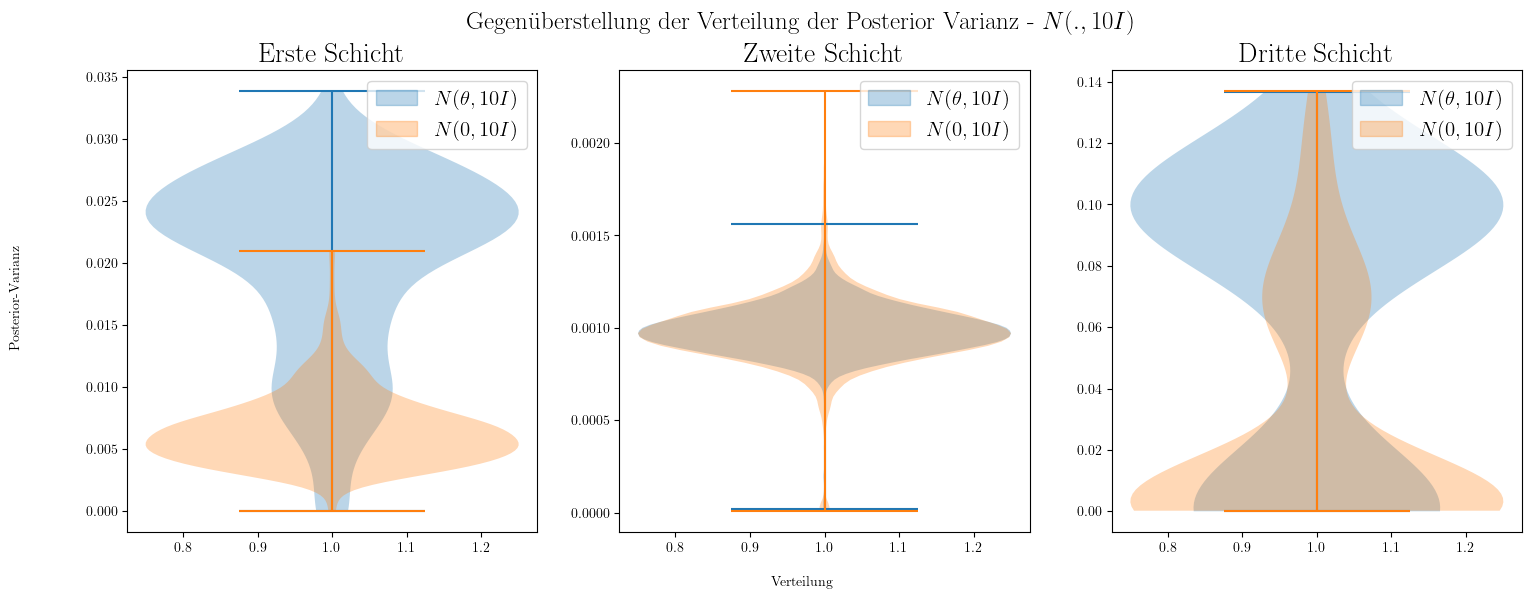

In [37]:
labels = []
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18, 6))
add_label(ax1.violinplot(np.power(ideal_model.layers[0]._posterior(np.array([0])).stddev().numpy(), 2)), r"$N(\theta, 10I)$")
add_label(ax1.violinplot(np.power(base_model.layers[0]._posterior(np.array([0])).stddev().numpy(), 2)), r"$N(0, 10I)$")
ax1.set_title("Erste Schicht")
ax1.legend(*zip(*labels), loc="upper right")
add_label(ax2.violinplot(np.power(ideal_model.layers[2]._posterior(np.array([0])).stddev().numpy(), 2)), r"$N(\theta, 10I)$")
add_label(ax2.violinplot(np.power(base_model.layers[2]._posterior(np.array([0])).stddev().numpy(), 2)), r"$N(0, 10I)$")
ax2.set_title("Zweite Schicht")
ax2.legend(*zip(*labels[2:]), loc="upper right")
add_label(ax3.violinplot(np.power(ideal_model.layers[4]._posterior(np.array([0])).stddev().numpy(), 2)), r"$N(\theta, 10I)$")
add_label(ax3.violinplot(np.power(base_model.layers[4]._posterior(np.array([0])).stddev().numpy(), 2)), r"$N(0, 10I)$")
ax3.set_title("Dritte Schicht")
ax3.legend(*zip(*labels[4:]), loc="upper right")
fig.text(0.5, .95, r"Gegenüberstellung der Verteilung der Posterior Varianz - $N(., 10I)$", ha="center", fontsize=18)
fig.text(0.5, 0.02, 'Verteilung', ha='center')
fig.text(0.06, 0.5, 'Posterior-Varianz', va='center', rotation='vertical')
plt.savefig("bilder/deep_bnn/dbnn_prior_10_gegenueb.png", dpi=1000, bbox_inches='tight')
plt.show()

### N(0, .1)

In [38]:
batch_size = 1000
kl_weight = 1/int(X_pred.shape[0]/batch_size)
cb = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=1e-4, patience = 500, mode = "min", verbose = 1)

base_model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(3,)), 
    tfp.layers.DenseVariational(units=100, make_posterior_fn=posterior, make_prior_fn=prior_base_p1, kl_weight=kl_weight),
    tf.keras.layers.Activation("relu"),
    tfp.layers.DenseVariational(units=100, make_posterior_fn=posterior, make_prior_fn=prior_base_p1, kl_weight=kl_weight),
    tf.keras.layers.Activation("relu"),
    tfp.layers.DenseVariational(units=1, make_posterior_fn=posterior, make_prior_fn=prior_base_p1, kl_weight=kl_weight),
    tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc = t, scale=.1))
])
base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss = neg_log_like)
base_model.fit(X_pred, y_true, epochs = 10000, verbose = False, batch_size = batch_size, callbacks=cb, validation_split=.3)

Epoch 1253: early stopping


In [39]:
X_pred_ = np.atleast_2d(np.linspace(-2,2, 100)).T
X_pred_ = np.hstack((X_pred_, X_pred_**2, X_pred_**3))


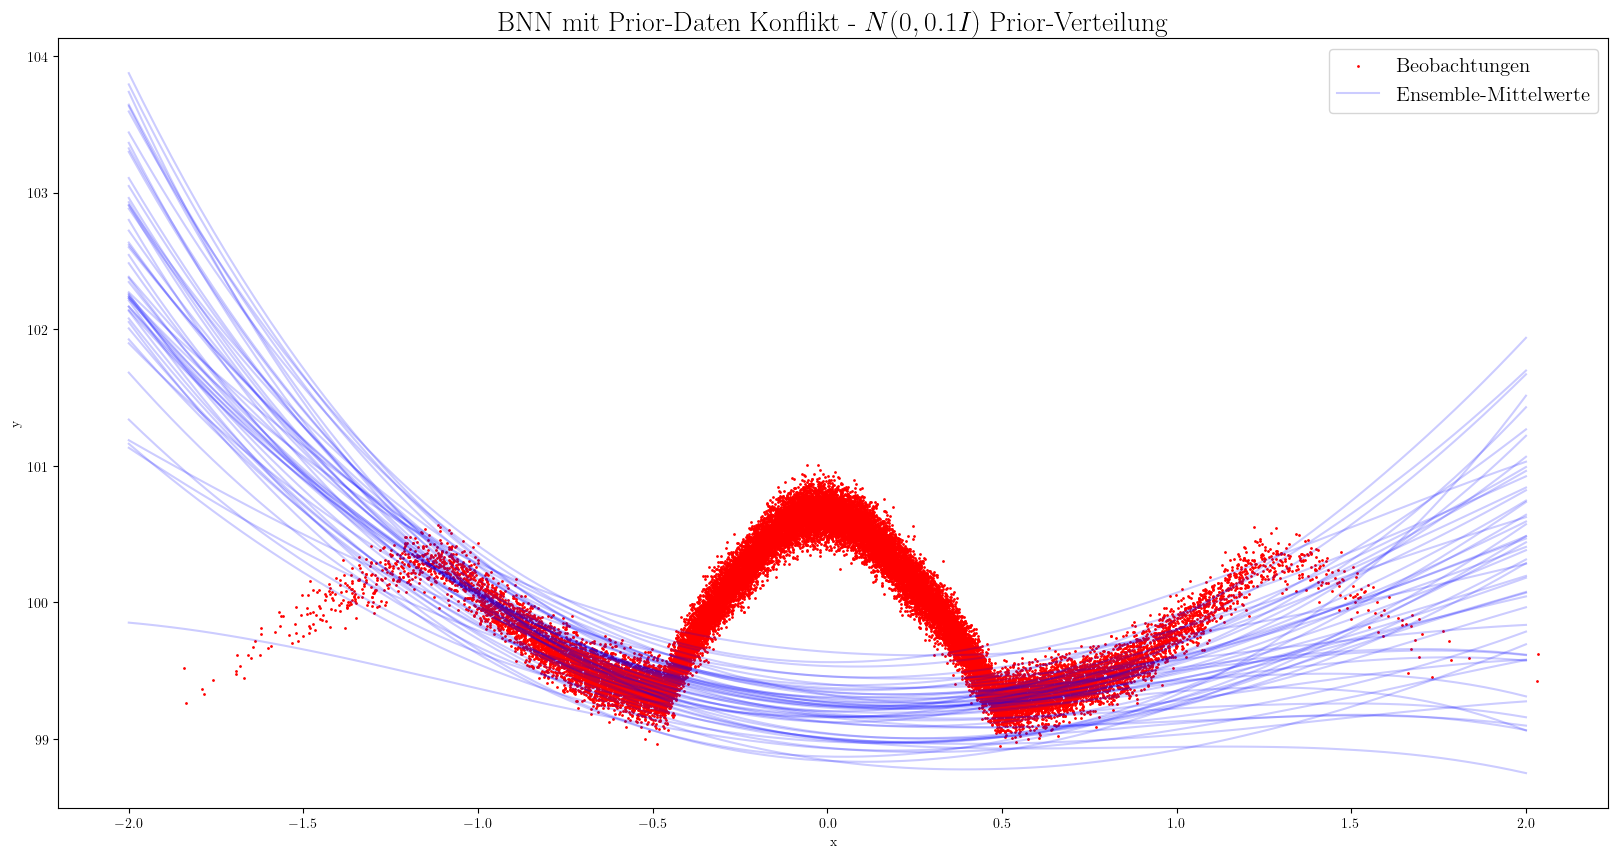

In [40]:
plt.figure(figsize=(20,10))
plt.scatter(X_pred[:,0], y_true, color="red", s=1, label="Beobachtungen")
plt.title(r"BNN mit Prior-Daten Konflikt - $N(0, 0.1I)$ Prior-Verteilung")
plt.xlabel("x")
plt.ylabel("y")
for i in range(50):
    plt.plot(X_pred_[:,0], base_model(X_pred_).mean(), color= "blue", alpha = .2, label="Ensemble-Mittelwerte" if i == 0 else None)
plt.legend(loc="upper right")
plt.savefig("bilder/deep_bnn/dbnn_prior_p1.png", dpi=1000, bbox_inches='tight')
plt.show()

Erwartungswerte

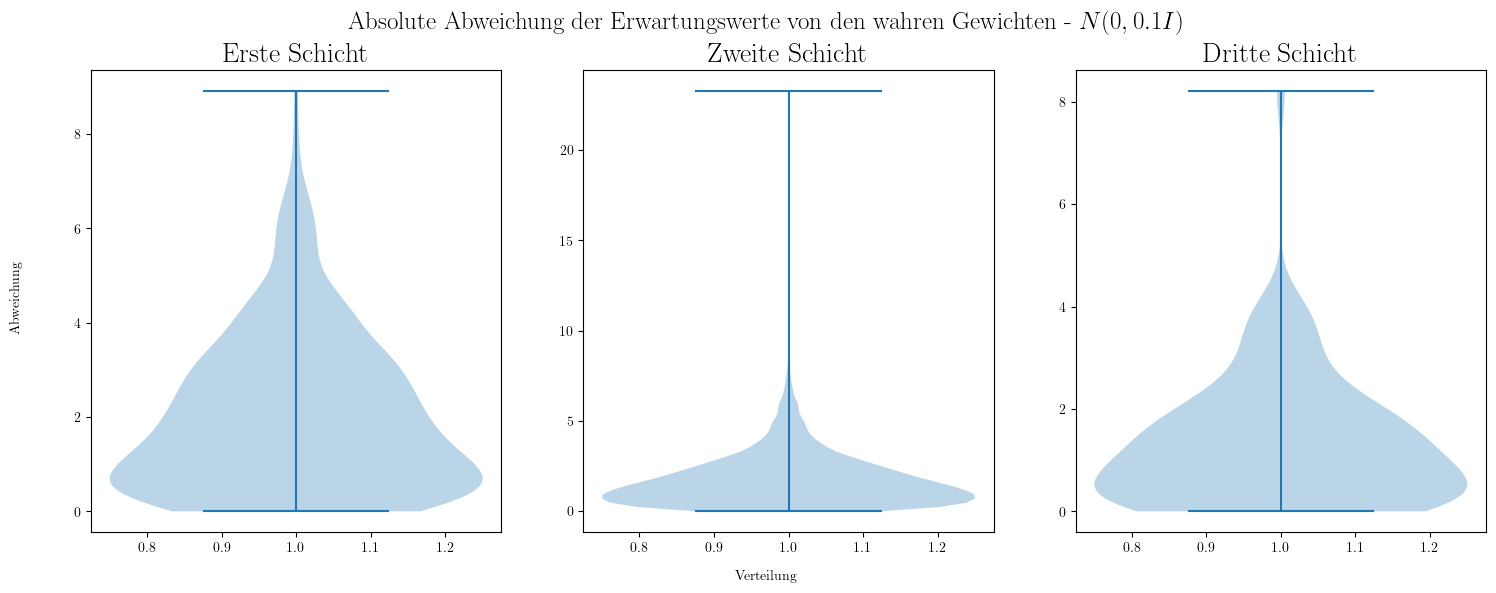

In [41]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18, 6))
ax1.violinplot(np.abs(np.hstack((k1.ravel(),b1.ravel())) - base_model.layers[0]._posterior(np.array([0])).mean().numpy()))
ax1.set_title("Erste Schicht")
ax2.violinplot(np.abs(np.hstack((k2.ravel(),b2.ravel())) - base_model.layers[2]._posterior(np.array([0])).mean().numpy()))
ax2.set_title("Zweite Schicht")
ax3.violinplot(np.abs(np.hstack((k3.ravel(),b3.ravel())) - base_model.layers[4]._posterior(np.array([0])).mean().numpy()))
ax3.set_title("Dritte Schicht")
fig.text(0.5, .95, r"Absolute Abweichung der Erwartungswerte von den wahren Gewichten - $N(0, 0.1I)$", ha="center", fontsize=18)
fig.text(0.5, 0.03, 'Verteilung', ha='center')
fig.text(0.08, 0.5, 'Abweichung', va='center', rotation='vertical')
plt.savefig("bilder/deep_bnn/dbnn_prior_p1_evals.png", dpi=1000, bbox_inches='tight')
plt.show()

Durchschnittliche Varianz

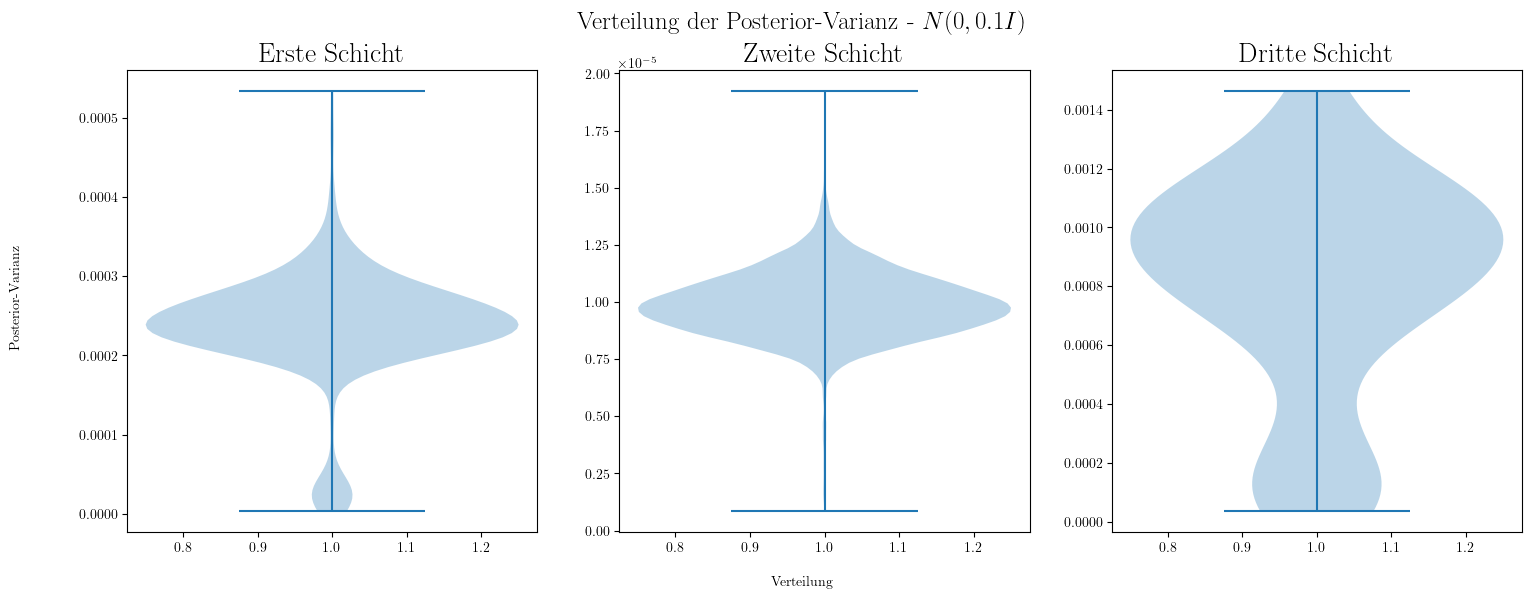

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18, 6))
ax1.violinplot(np.power(base_model.layers[0]._posterior(np.array([0])).stddev().numpy(), 2))
ax1.set_title("Erste Schicht")
ax2.violinplot(np.power(base_model.layers[2]._posterior(np.array([0])).stddev().numpy(), 2))
ax2.set_title("Zweite Schicht")
ax3.violinplot(np.power(base_model.layers[4]._posterior(np.array([0])).stddev().numpy(), 2))
ax3.set_title("Dritte Schicht")
fig.text(0.5, .95, r"Verteilung der Posterior-Varianz - $N(0, 0.1I)$", ha="center", fontsize=18)
fig.text(0.5, 0.02, 'Verteilung', ha='center')
fig.text(0.06, 0.5, 'Posterior-Varianz', va='center', rotation='vertical')
plt.savefig("bilder/deep_bnn/dbnn_prior_p1_stddev.png", dpi=1000, bbox_inches='tight')
plt.show()

#### Kein prior Daten Konflikt

In [43]:
batch_size = 1000
kl_weight = 1/int(X_pred.shape[0]/batch_size)
cb = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=1e-4, patience = 500, mode = "min", verbose = 1)

ideal_model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(3,)), 
    tfp.layers.DenseVariational(units=100, make_posterior_fn=posterior, make_prior_fn=prior_exact_p1, kl_weight=kl_weight),
    tf.keras.layers.Activation("relu"),
    tfp.layers.DenseVariational(units=100, make_posterior_fn=posterior, make_prior_fn=prior_exact_p1_1, kl_weight=kl_weight),
    tf.keras.layers.Activation("relu"),
    tfp.layers.DenseVariational(units=1, make_posterior_fn=posterior, make_prior_fn=prior_exact_p1_2, kl_weight=kl_weight),
    tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc = t, scale=.1))
])
ideal_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss = neg_log_like)
ideal_model.fit(X_pred, y_true, epochs = 10000, verbose = False, batch_size = batch_size, callbacks=cb, validation_split=.3)

Epoch 1781: early stopping


In [44]:
X_pred_ = np.atleast_2d(np.linspace(-2,2, 100)).T
X_pred_ = np.hstack((X_pred_, X_pred_**2, X_pred_**3))


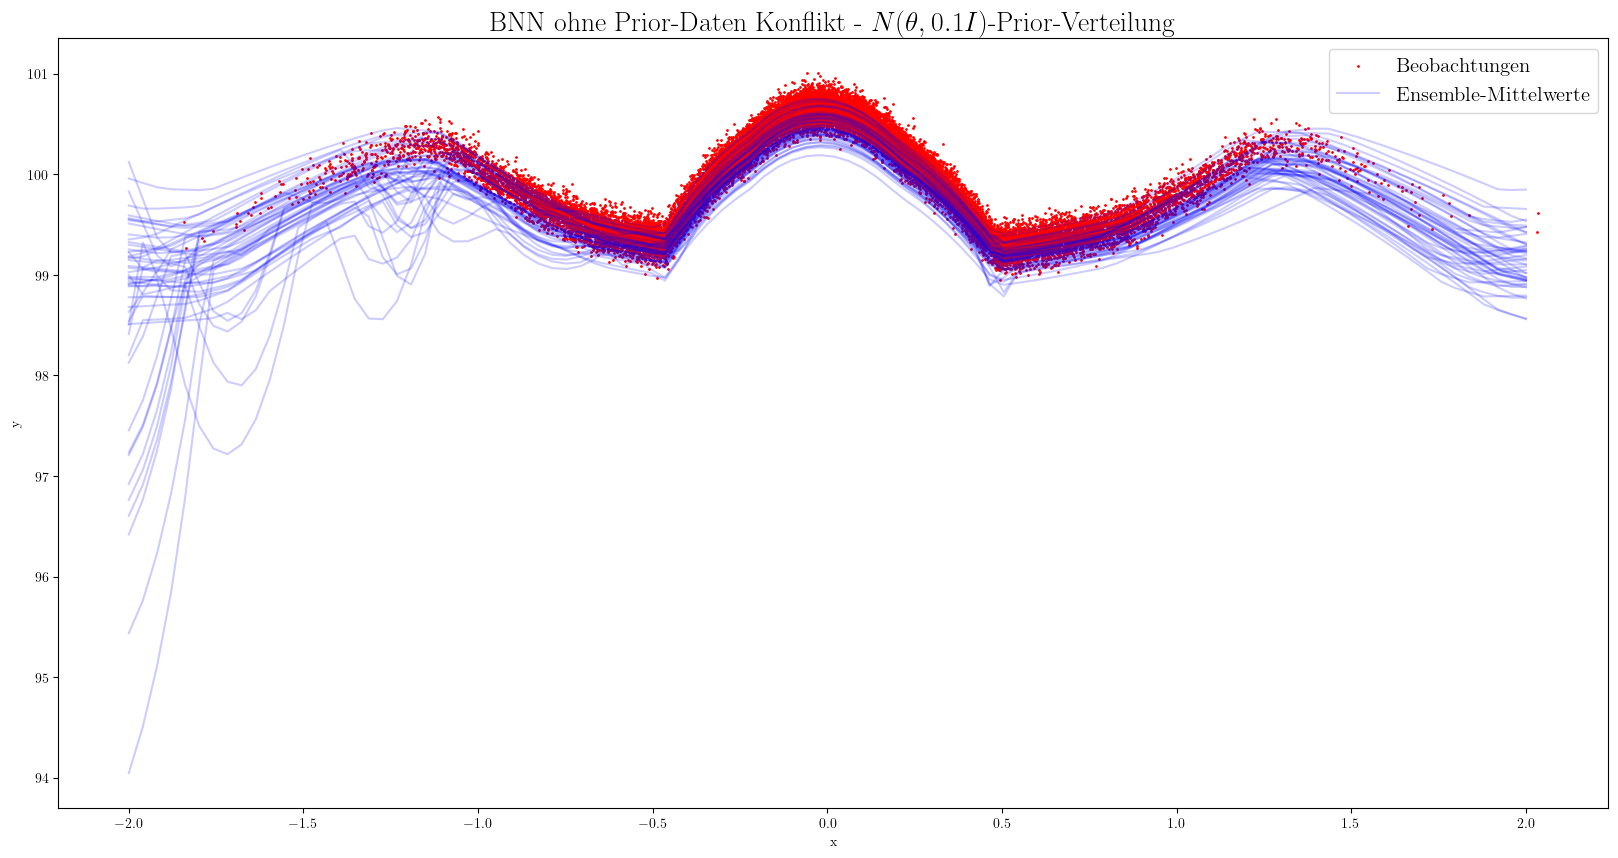

In [45]:
plt.figure(figsize=(20,10))
plt.scatter(X_pred[:,0], y_true, color="red", s=1, label="Beobachtungen")
plt.title(r"BNN ohne Prior-Daten Konflikt - $N(\theta, 0.1I)$-Prior-Verteilung")
plt.xlabel("x")
plt.ylabel("y")
for i in range(50):
    plt.plot(X_pred_[:,0], ideal_model(X_pred_).mean(), color= "blue", alpha = .2, label="Ensemble-Mittelwerte" if i == 0 else None)
plt.legend(loc="upper right")
plt.savefig("bilder/deep_bnn/dbnn_prior_exact_p1.png", dpi=1000, bbox_inches='tight')
plt.show()

Erwartungswerte

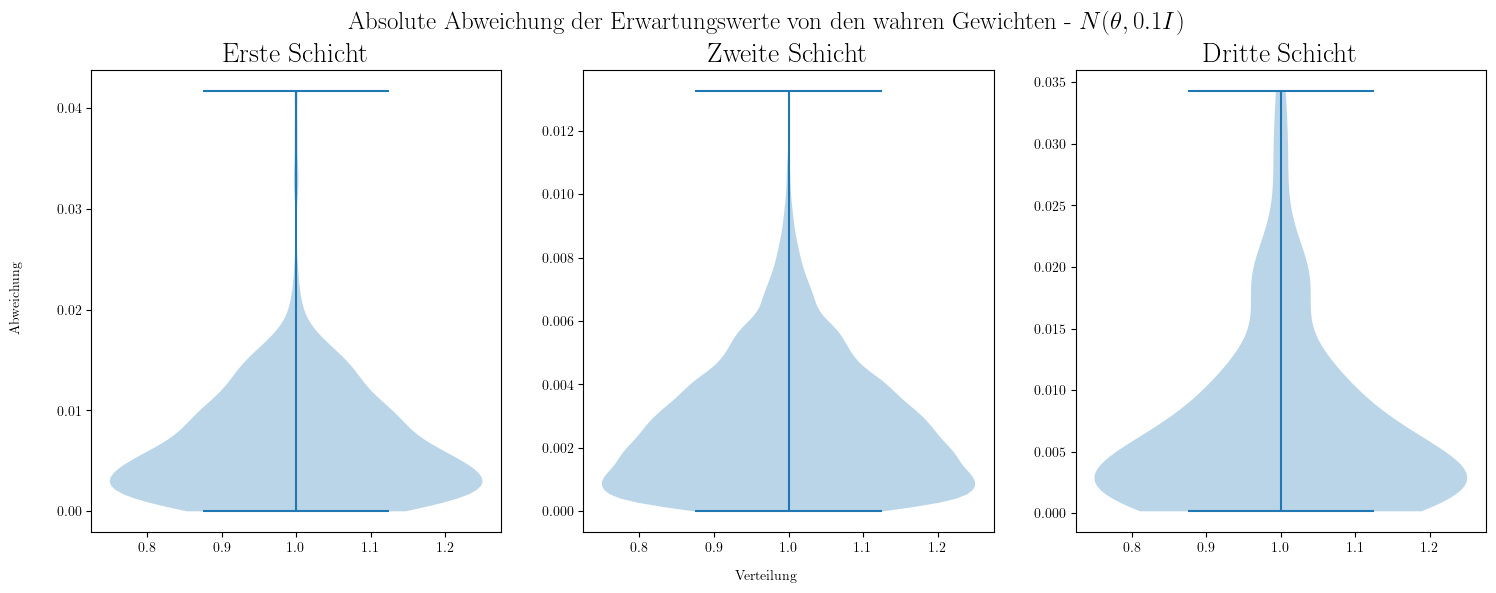

In [46]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18, 6))
ax1.violinplot(np.abs(np.hstack((k1.ravel(),b1.ravel())) - ideal_model.layers[0]._posterior(np.array([0])).mean().numpy()))
ax1.set_title("Erste Schicht")
ax2.violinplot(np.abs(np.hstack((k2.ravel(),b2.ravel())) - ideal_model.layers[2]._posterior(np.array([0])).mean().numpy()))
ax2.set_title("Zweite Schicht")
ax3.violinplot(np.abs(np.hstack((k3.ravel(),b3.ravel())) - ideal_model.layers[4]._posterior(np.array([0])).mean().numpy()))
ax3.set_title("Dritte Schicht")
fig.text(0.5, .95, r"Absolute Abweichung der Erwartungswerte von den wahren Gewichten - $N(\theta, 0.1I)$", ha="center", fontsize=18)
fig.text(0.5, 0.03, 'Verteilung', ha='center')
fig.text(0.08, 0.5, 'Abweichung', va='center', rotation='vertical')
plt.savefig("bilder/deep_bnn/dbnn_prior_exact_p1_evals.png", dpi=1000, bbox_inches='tight')
plt.show()

Durchschnittliche Varianz

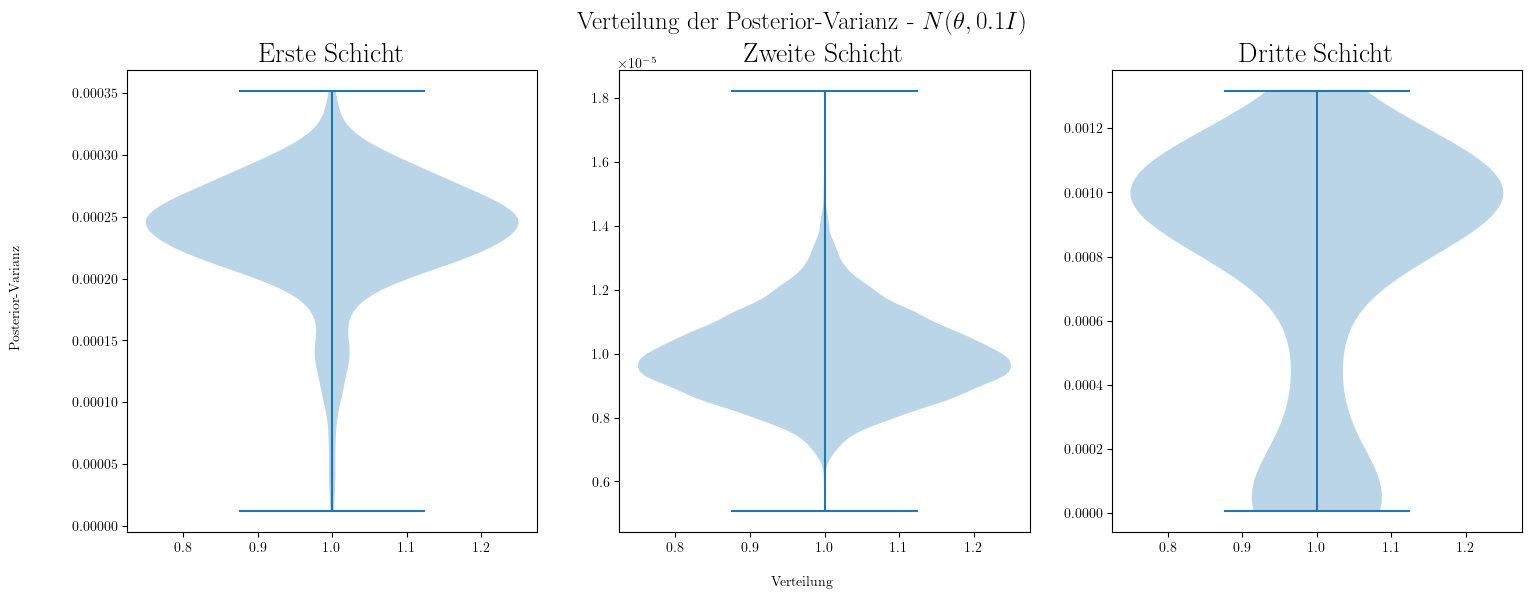

In [47]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18, 6))
ax1.violinplot(np.power(ideal_model.layers[0]._posterior(np.array([0])).stddev().numpy(), 2))
ax1.set_title("Erste Schicht")
ax2.violinplot(np.power(ideal_model.layers[2]._posterior(np.array([0])).stddev().numpy(), 2))
ax2.set_title("Zweite Schicht")
ax3.violinplot(np.power(ideal_model.layers[4]._posterior(np.array([0])).stddev().numpy(), 2))
ax3.set_title("Dritte Schicht")
fig.text(0.5, .95, r"Verteilung der Posterior-Varianz - $N(\theta, 0.1I)$", ha="center", fontsize=18)
fig.text(0.5, 0.02, 'Verteilung', ha='center')
fig.text(0.06, 0.5, 'Posterior-Varianz', va='center', rotation='vertical')
plt.savefig("bilder/deep_bnn/dbnn_prior_exact_p1_stddev.png", dpi=1000, bbox_inches='tight')
plt.show()

Gegenüberstellen der Posterior-Varianzen

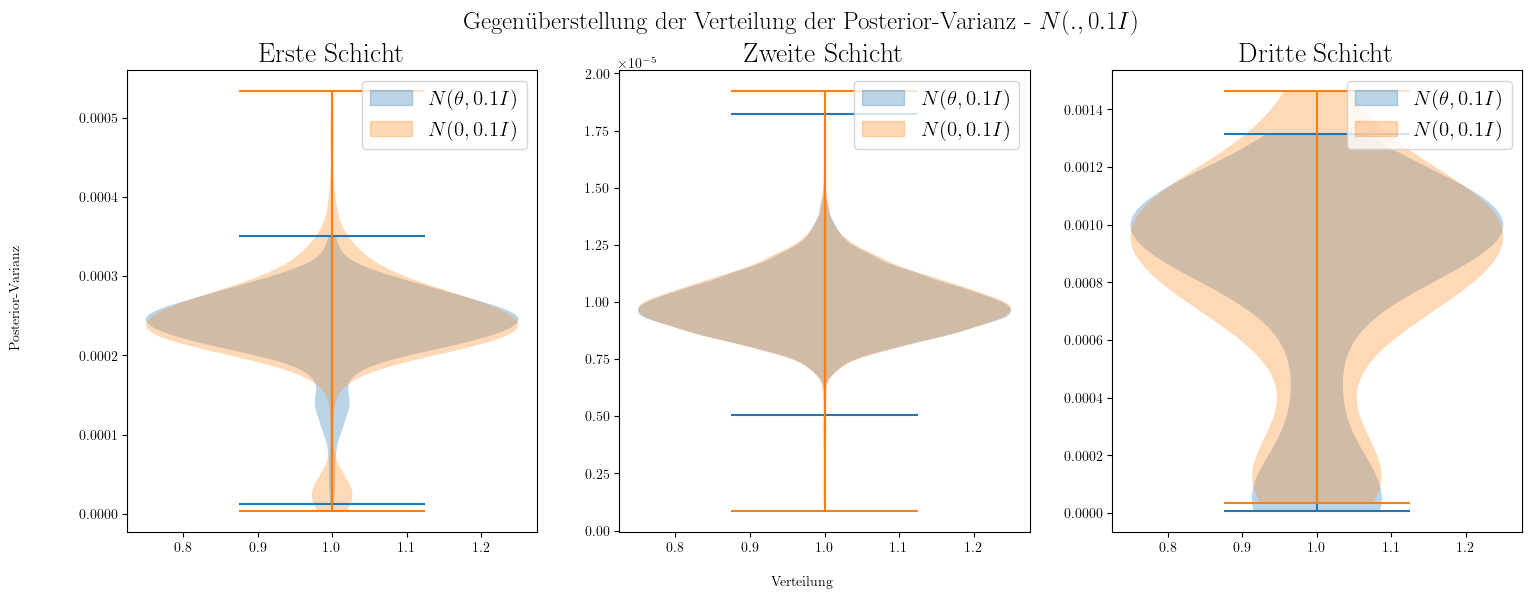

In [48]:
labels = []
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18, 6))
add_label(ax1.violinplot(np.power(ideal_model.layers[0]._posterior(np.array([0])).stddev().numpy(), 2)), r"$N(\theta, 0.1I)$")
add_label(ax1.violinplot(np.power(base_model.layers[0]._posterior(np.array([0])).stddev().numpy(), 2)), r"$N(0, 0.1I)$")
ax1.set_title("Erste Schicht")
ax1.legend(*zip(*labels), loc="upper right")
add_label(ax2.violinplot(np.power(ideal_model.layers[2]._posterior(np.array([0])).stddev().numpy(), 2)), r"$N(\theta, 0.1I)$")
add_label(ax2.violinplot(np.power(base_model.layers[2]._posterior(np.array([0])).stddev().numpy(), 2)), r"$N(0, 0.1I)$")
ax2.set_title("Zweite Schicht")
ax2.legend(*zip(*labels[2:]), loc="upper right")
add_label(ax3.violinplot(np.power(ideal_model.layers[4]._posterior(np.array([0])).stddev().numpy(), 2)), r"$N(\theta, 0.1I)$")
add_label(ax3.violinplot(np.power(base_model.layers[4]._posterior(np.array([0])).stddev().numpy(), 2)), r"$N(0, 0.1I)$")
ax3.set_title("Dritte Schicht")
ax3.legend(*zip(*labels[4:]), loc="upper right")
fig.text(0.5, .95, r"Gegenüberstellung der Verteilung der Posterior-Varianz - $N(., 0.1I)$", ha="center", fontsize=18)
fig.text(0.5, 0.02, 'Verteilung', ha='center')
fig.text(0.06, 0.5, 'Posterior-Varianz', va='center', rotation='vertical')
plt.savefig("bilder/deep_bnn/dbnn_prior_p1_gegenueb.png", dpi=1000, bbox_inches='tight')
plt.show()

In [49]:
from scipy.stats import mannwhitneyu

In [50]:
mannwhitneyu(ideal_model.layers[0]._posterior(np.array([0])).mean().numpy(), np.hstack((k1.ravel(),b1.ravel())), alternative="two-sided")

MannwhitneyuResult(statistic=80011.0, pvalue=0.9974364429486555)

In [51]:
mannwhitneyu(ideal_model.layers[2]._posterior(np.array([0])).mean().numpy(), np.hstack((k2.ravel(),b2.ravel())), alternative="two-sided")

MannwhitneyuResult(statistic=51004970.5, pvalue=0.9999441631546171)

In [52]:
mannwhitneyu(ideal_model.layers[4]._posterior(np.array([0])).mean().numpy(), np.hstack((k3.ravel(),b3.ravel())), alternative="two-sided")

MannwhitneyuResult(statistic=5085.0, pvalue=0.9711956430739739)

In [53]:
mannwhitneyu(base_model.layers[0]._posterior(np.array([0])).mean().numpy(), np.hstack((k1.ravel(),b1.ravel())), alternative="two-sided")

MannwhitneyuResult(statistic=116260.0, pvalue=1.3232392637702776e-28)

In [54]:
mannwhitneyu(base_model.layers[2]._posterior(np.array([0])).mean().numpy(), np.hstack((k2.ravel(),b2.ravel())), alternative="two-sided")

MannwhitneyuResult(statistic=15581790.0, pvalue=0.0)

In [55]:
mannwhitneyu(base_model.layers[4]._posterior(np.array([0])).mean().numpy(), np.hstack((k3.ravel(),b3.ravel())), alternative="two-sided")

MannwhitneyuResult(statistic=4726.0, pvalue=0.36795446432154666)